# PINNs - SIR model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.integrate import odeint
import torch.optim as optim
import time
from pinn_SIR import PINN
from pinn_SEIHCR import PINN_SEIHCR
np.random.seed(seed= 12)

## Generate SIR data

### Function generate data:

In [2]:
def data_SIR(beta_in, gamma_in, t_max= 250, noisy= False, noise_level= 0.01):

    # Total population, N.
    N = 1000000
    # Initial number of infected and recovered individuals, I0 and R0.
    I0, R0 = 1, 0
    # Everyone else, S0, is susceptible to infection initially.
    S0 = N - I0 - R0
    # Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
    beta, gamma = beta_in, gamma_in 
    # A grid of time points (in days)
    dt = 1
    t = np.arange(0, t_max, dt)
    #print(t)

    def model(y, t, N, beta, gamma):
        S, I, R = y
        dSdt = -beta * S * I / N
        dIdt = beta * S * I / N - gamma * I
        dRdt = gamma * I
        return dSdt, dIdt, dRdt

    # Initial conditions vector
    y0 = S0, I0, R0

    # Integrate the SIR equations over the time grid, t.
    ret = odeint(model, y0, t, args=(N, beta, gamma))
    S, I, R = ret.T

    s = torch.from_numpy(S / N).type(torch.float32)
    i = torch.from_numpy(I / N).type(torch.float32)
    r = torch.from_numpy(R / N).type(torch.float32)

    t = torch.from_numpy(t).type(torch.float32)

    if noisy:

        s_noisy = s + torch.empty(s.shape[0]).normal_(mean= 0, std= noise_level)
        i_noisy = i + torch.empty(i.shape[0]).normal_(mean= 0, std= noise_level)
        r_noisy = r + torch.empty(r.shape[0]).normal_(mean= 0, std= noise_level)

        s = s_noisy.clone()
        i = i_noisy.clone()
        r = r_noisy.clone()



    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(t, s, color= 'b', alpha=0.5, lw=2, label='Susceptible', marker= 'o')
    ax.plot(t, i, color= 'r', alpha=0.5, lw=2, label='Infected', marker= 'o')
    ax.plot(t, r, color= 'g', alpha=0.5, lw=2, label='Removed', marker= 'o')
    ax.set_xlabel('Time', fontsize= 15)
    ax.set_ylabel('Population fraction', fontsize= 15)
    plt.legend()
    plt.show()

    return s, i, t

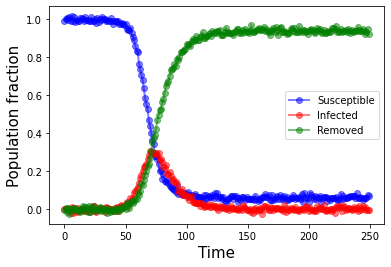

In [3]:
s, i, t = data_SIR(beta_in= 0.3, gamma_in= 0.1, t_max= 250, noisy= True, noise_level= 0.01)

### Training function

In [4]:
def train(s_tensor, i_tensor, t_tensor, layers, lr= 0.001, epochs = 100000, lambda_1= 0, lambda_2= 0):

    model   = PINN(s_tensor, 
                   i_tensor, 
                   t_tensor, 
                   layers_size= layers,    # indentify from where this 3 comes from  
                   out_size = 2,     # psi and p
                   params_list= None)


    optimizer = optim.Adam(params= model.parameters(), 
                           lr= lr, 
                           weight_decay= 0.0)


    for epoch in range(epochs):

        t0 = time.time()

        l1_regularization = 0.
        l2_regularization = 0.

        s_model, i_model, f_s, f_i = model.net(s_tensor, i_tensor, t_tensor)
        loss_ = model.loss(s_tensor, i_tensor, s_model, i_model, f_s, f_i)
        
        for param in list(model.parameters())[2:]:
            l1_regularization += torch.norm(param, 1)
            l2_regularization += torch.norm(param, 2)**2

        # Regularization 
        loss_ += lambda_1 * l1_regularization
        loss_ += lambda_1 * l2_regularization
        
        loss_print  = loss_
        optimizer.zero_grad()   # Clear gradients for the next mini-batches
        loss_.backward()         # Backpropagation, compute gradients
        optimizer.step()

        
        ### Training status
        if epoch % 1000 == 0:

            t1 = time.time()
                
            print('Epoch %d, Loss= %.8f, beta= %.4f, gamma= %.4f Time= %.4f' % (epoch, 
                                                                                loss_print,
                                                                                list(model.parameters())[0].item(),
                                                                                list(model.parameters())[1].item(),
                                                                                t1-t0))

    return list(model.parameters())[0].item(), list(model.parameters())[1].item()

## Training for different $(\beta, \gamma)$ pairs

SIR parameters:
beta =  0.3
gamma =  0.1


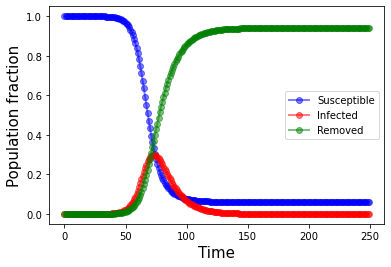

Training
Epoch 0, Loss= 11.41639042, beta= -0.0010, gamma= 0.0001 Time= 0.0039
Epoch 1000, Loss= 0.16125925, beta= 0.1032, gamma= 0.0307 Time= 0.0065
Epoch 2000, Loss= 0.16102727, beta= 0.2340, gamma= 0.0740 Time= 0.0066
Epoch 3000, Loss= 0.16097757, beta= 0.2971, gamma= 0.0949 Time= 0.0072
Epoch 4000, Loss= 0.16096036, beta= 0.3104, gamma= 0.0993 Time= 0.0043
Epoch 5000, Loss= 0.16095431, beta= 0.3120, gamma= 0.0997 Time= 0.0053
Epoch 6000, Loss= 0.16095245, beta= 0.3123, gamma= 0.0998 Time= 0.0055
Epoch 7000, Loss= 0.16095100, beta= 0.3124, gamma= 0.0999 Time= 0.0074
Epoch 8000, Loss= 0.16095009, beta= 0.3126, gamma= 0.0999 Time= 0.0038
Epoch 9000, Loss= 0.16094945, beta= 0.3127, gamma= 0.1000 Time= 0.0044
Epoch 10000, Loss= 0.16094913, beta= 0.3128, gamma= 0.1000 Time= 0.0042
Epoch 11000, Loss= 0.16094892, beta= 0.3108, gamma= 0.0991 Time= 0.0037
Epoch 12000, Loss= 0.16094883, beta= 0.3128, gamma= 0.1000 Time= 0.0061
Epoch 13000, Loss= 0.16094875, beta= 0.3128, gamma= 0.1000 Time= 0

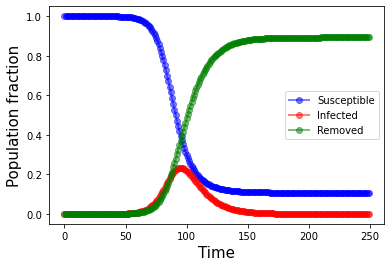

Training
Epoch 0, Loss= 11.41558933, beta= -0.0010, gamma= 0.0009 Time= 0.0064
Epoch 1000, Loss= 0.16249721, beta= 0.0346, gamma= 0.0057 Time= 0.0040
Epoch 2000, Loss= 0.16242626, beta= 0.0989, gamma= 0.0341 Time= 0.0038
Epoch 3000, Loss= 0.16241263, beta= 0.1655, gamma= 0.0672 Time= 0.0046
Epoch 4000, Loss= 0.16240890, beta= 0.2111, gamma= 0.0899 Time= 0.0079
Epoch 5000, Loss= 0.16240676, beta= 0.2285, gamma= 0.0986 Time= 0.0133
Epoch 6000, Loss= 0.16240594, beta= 0.2312, gamma= 0.0999 Time= 0.0037
Epoch 7000, Loss= 0.16240567, beta= 0.2314, gamma= 0.1000 Time= 0.0036
Epoch 8000, Loss= 0.16240543, beta= 0.2314, gamma= 0.1000 Time= 0.0170
Epoch 9000, Loss= 0.16240543, beta= 0.2314, gamma= 0.1000 Time= 0.0056
Epoch 10000, Loss= 0.16240536, beta= 0.2314, gamma= 0.1000 Time= 0.0056
Epoch 11000, Loss= 0.16240528, beta= 0.2314, gamma= 0.1000 Time= 0.0066
Epoch 12000, Loss= 0.16240560, beta= 0.2305, gamma= 0.0995 Time= 0.0057
Epoch 13000, Loss= 0.16240519, beta= 0.2318, gamma= 0.1002 Time= 0

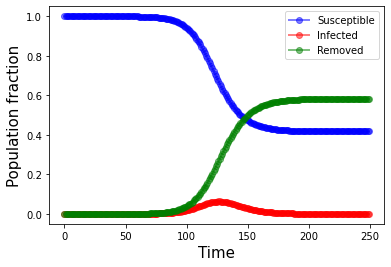

Training
Epoch 0, Loss= 2.03451252, beta= -0.0010, gamma= -0.0008 Time= 0.0075
Epoch 1000, Loss= 0.07005438, beta= 0.1317, gamma= 0.0750 Time= 0.0067
Epoch 2000, Loss= 0.06998596, beta= 0.2428, gamma= 0.1667 Time= 0.0057
Epoch 3000, Loss= 0.06997442, beta= 0.2698, gamma= 0.1902 Time= 0.0037
Epoch 4000, Loss= 0.06996681, beta= 0.2766, gamma= 0.1955 Time= 0.0137
Epoch 5000, Loss= 0.06996301, beta= 0.2800, gamma= 0.1980 Time= 0.0043
Epoch 6000, Loss= 0.06996182, beta= 0.2801, gamma= 0.1980 Time= 0.0037
Epoch 7000, Loss= 0.06996743, beta= 0.2628, gamma= 0.1850 Time= 0.0036
Epoch 8000, Loss= 0.06996076, beta= 0.2784, gamma= 0.1967 Time= 0.0059
Epoch 9000, Loss= 0.06996049, beta= 0.2758, gamma= 0.1948 Time= 0.0069
Epoch 10000, Loss= 0.06996027, beta= 0.2817, gamma= 0.1993 Time= 0.0108
Epoch 11000, Loss= 0.06996152, beta= 0.2726, gamma= 0.1926 Time= 0.0061
Epoch 12000, Loss= 0.06996012, beta= 0.2817, gamma= 0.1993 Time= 0.0042
Epoch 13000, Loss= 0.06996007, beta= 0.2820, gamma= 0.1995 Time= 0

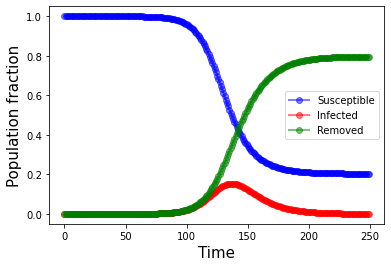

Training
Epoch 0, Loss= 5.72783566, beta= 0.0010, gamma= 0.0010 Time= 0.0084
Epoch 1000, Loss= 0.12991914, beta= 0.1518, gamma= 0.0943 Time= 0.0136
Epoch 2000, Loss= 0.12990502, beta= 0.1595, gamma= 0.0999 Time= 0.0118
Epoch 3000, Loss= 0.12990335, beta= 0.1597, gamma= 0.1000 Time= 0.0118
Epoch 4000, Loss= 0.12990206, beta= 0.1597, gamma= 0.1000 Time= 0.0063
Epoch 5000, Loss= 0.12990105, beta= 0.1597, gamma= 0.1000 Time= 0.0081
Epoch 6000, Loss= 0.12990080, beta= 0.1597, gamma= 0.1000 Time= 0.0140
Epoch 7000, Loss= 0.12990093, beta= 0.1598, gamma= 0.1000 Time= 0.0067
Epoch 8000, Loss= 0.12990114, beta= 0.1603, gamma= 0.1004 Time= 0.0056
Epoch 9000, Loss= 0.12990066, beta= 0.1597, gamma= 0.1000 Time= 0.0042
Epoch 10000, Loss= 0.12991327, beta= 0.1573, gamma= 0.0986 Time= 0.0039
Epoch 11000, Loss= 0.12990083, beta= 0.1598, gamma= 0.1001 Time= 0.0046
Epoch 12000, Loss= 0.12990083, beta= 0.1599, gamma= 0.1001 Time= 0.0035
Epoch 13000, Loss= 0.12990072, beta= 0.1597, gamma= 0.1000 Time= 0.0

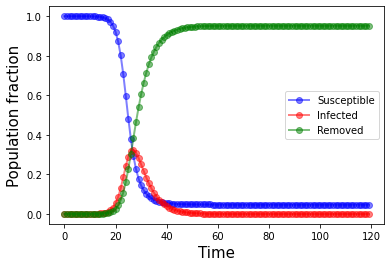

Training
Epoch 0, Loss= 1.07979095, beta= 0.0010, gamma= -0.0005 Time= 0.0037
Epoch 1000, Loss= 0.14127518, beta= 0.4231, gamma= 0.1051 Time= 0.0025
Epoch 2000, Loss= 0.14121291, beta= 0.8105, gamma= 0.2024 Time= 0.0030
Epoch 3000, Loss= 0.14120416, beta= 0.9684, gamma= 0.2422 Time= 0.0022
Epoch 4000, Loss= 0.14120270, beta= 0.9957, gamma= 0.2491 Time= 0.0032
Epoch 5000, Loss= 0.14120077, beta= 0.9966, gamma= 0.2492 Time= 0.0033
Epoch 6000, Loss= 0.14119995, beta= 0.9978, gamma= 0.2496 Time= 0.0020
Epoch 7000, Loss= 0.14120294, beta= 0.9940, gamma= 0.2484 Time= 0.0022
Epoch 8000, Loss= 0.14119956, beta= 0.9934, gamma= 0.2484 Time= 0.0022
Epoch 9000, Loss= 0.14119916, beta= 0.9985, gamma= 0.2498 Time= 0.0021
Epoch 10000, Loss= 0.14119926, beta= 0.9930, gamma= 0.2486 Time= 0.0028
Epoch 11000, Loss= 0.14119932, beta= 0.9989, gamma= 0.2499 Time= 0.0022
Epoch 12000, Loss= 0.14119905, beta= 0.9982, gamma= 0.2498 Time= 0.0021
Epoch 13000, Loss= 0.14119904, beta= 0.9980, gamma= 0.2497 Time= 0.

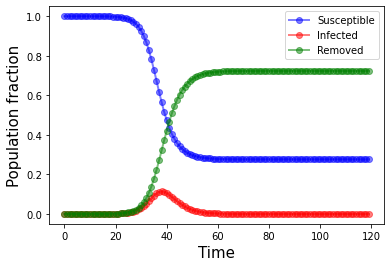

Training
Epoch 0, Loss= 8.53621674, beta= -0.0010, gamma= -0.0008 Time= 0.0023
Epoch 1000, Loss= 0.09931771, beta= 0.0324, gamma= 0.0077 Time= 0.0023
Epoch 2000, Loss= 0.09912982, beta= 0.1200, gamma= 0.0447 Time= 0.0029
Epoch 3000, Loss= 0.09907834, beta= 0.2552, gamma= 0.1115 Time= 0.0020
Epoch 4000, Loss= 0.09905676, beta= 0.4284, gamma= 0.2028 Time= 0.0019
Epoch 5000, Loss= 0.09904248, beta= 0.6103, gamma= 0.2993 Time= 0.0020
Epoch 6000, Loss= 0.09903479, beta= 0.7632, gamma= 0.3801 Time= 0.0019
Epoch 7000, Loss= 0.09903219, beta= 0.8562, gamma= 0.4293 Time= 0.0028
Epoch 8000, Loss= 0.09903221, beta= 0.8864, gamma= 0.4450 Time= 0.0022
Epoch 9000, Loss= 0.09903222, beta= 0.8889, gamma= 0.4466 Time= 0.0025
Epoch 10000, Loss= 0.09903120, beta= 0.8799, gamma= 0.4419 Time= 0.0020
Epoch 11000, Loss= 0.09903120, beta= 0.8824, gamma= 0.4432 Time= 0.0032
Epoch 12000, Loss= 0.09903106, beta= 0.8796, gamma= 0.4419 Time= 0.0052
Epoch 13000, Loss= 0.09903090, beta= 0.8866, gamma= 0.4455 Time= 0

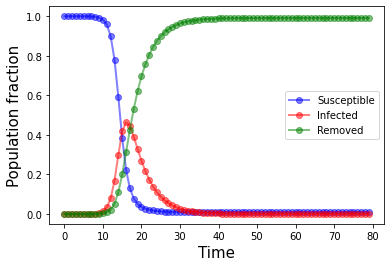

Training
Epoch 0, Loss= 7.40491438, beta= -0.0010, gamma= 0.0007 Time= 0.0028
Epoch 1000, Loss= 0.14974439, beta= 0.0828, gamma= 0.0149 Time= 0.0016
Epoch 2000, Loss= 0.14954355, beta= 0.2658, gamma= 0.0510 Time= 0.0023
Epoch 3000, Loss= 0.14948614, beta= 0.5208, gamma= 0.1013 Time= 0.0017
Epoch 4000, Loss= 0.14944914, beta= 0.8041, gamma= 0.1572 Time= 0.0028
Epoch 5000, Loss= 0.14943206, beta= 1.0510, gamma= 0.2058 Time= 0.0017
Epoch 6000, Loss= 0.14942734, beta= 1.2067, gamma= 0.2364 Time= 0.0016
Epoch 7000, Loss= 0.14942652, beta= 1.2655, gamma= 0.2479 Time= 0.0017
Epoch 8000, Loss= 0.14942627, beta= 1.2745, gamma= 0.2497 Time= 0.0017
Epoch 9000, Loss= 0.14942625, beta= 1.2741, gamma= 0.2496 Time= 0.0016
Epoch 10000, Loss= 0.14942615, beta= 1.2756, gamma= 0.2499 Time= 0.0025
Epoch 11000, Loss= 0.14944902, beta= 1.2737, gamma= 0.2500 Time= 0.0016
Epoch 12000, Loss= 0.14942610, beta= 1.2760, gamma= 0.2500 Time= 0.0017
Epoch 13000, Loss= 0.14942610, beta= 1.2756, gamma= 0.2499 Time= 0.

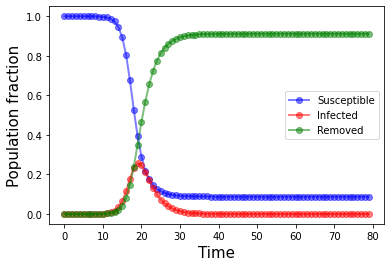

Training
Epoch 0, Loss= 1.13916898, beta= -0.0010, gamma= 0.0001 Time= 0.0034
Epoch 1000, Loss= 0.13659033, beta= 0.6753, gamma= 0.2022 Time= 0.0016
Epoch 2000, Loss= 0.13653198, beta= 1.1889, gamma= 0.3575 Time= 0.0021
Epoch 3000, Loss= 0.13651566, beta= 1.4257, gamma= 0.4289 Time= 0.0016
Epoch 4000, Loss= 0.13651390, beta= 1.4871, gamma= 0.4474 Time= 0.0016
Epoch 5000, Loss= 0.13650547, beta= 1.4922, gamma= 0.4489 Time= 0.0036
Epoch 6000, Loss= 0.13650368, beta= 1.4927, gamma= 0.4490 Time= 0.0029
Epoch 7000, Loss= 0.13650292, beta= 1.4938, gamma= 0.4493 Time= 0.0037
Epoch 8000, Loss= 0.13653241, beta= 1.4888, gamma= 0.4466 Time= 0.0021
Epoch 9000, Loss= 0.13650626, beta= 1.4910, gamma= 0.4489 Time= 0.0020
Epoch 10000, Loss= 0.13650320, beta= 1.4918, gamma= 0.4488 Time= 0.0029
Epoch 11000, Loss= 0.13650240, beta= 1.4935, gamma= 0.4493 Time= 0.0018
Epoch 12000, Loss= 0.13650250, beta= 1.4923, gamma= 0.4489 Time= 0.0016
Epoch 13000, Loss= 0.13650326, beta= 1.4859, gamma= 0.4471 Time= 0.

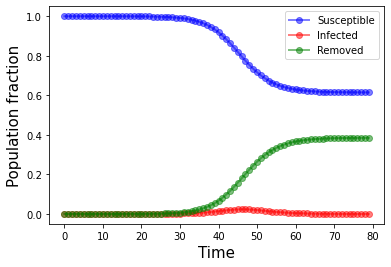

Training
Epoch 0, Loss= 4.59973860, beta= 0.0010, gamma= -0.0010 Time= 0.0038
Epoch 1000, Loss= 0.02860704, beta= 0.0170, gamma= 0.0045 Time= 0.0020
Epoch 2000, Loss= 0.02843060, beta= 0.0709, gamma= 0.0175 Time= 0.0016
Epoch 3000, Loss= 0.02840689, beta= 0.1551, gamma= 0.0546 Time= 0.0016
Epoch 4000, Loss= 0.02839376, beta= 0.2691, gamma= 0.1327 Time= 0.0017
Epoch 5000, Loss= 0.02838291, beta= 0.4127, gamma= 0.2583 Time= 0.0018
Epoch 6000, Loss= 0.02837420, beta= 0.5765, gamma= 0.4166 Time= 0.0017
Epoch 7000, Loss= 0.02836811, beta= 0.7397, gamma= 0.5775 Time= 0.0018
Epoch 8000, Loss= 0.02836562, beta= 0.8018, gamma= 0.6669 Time= 0.0016
Epoch 9000, Loss= 0.02836482, beta= 0.8226, gamma= 0.7023 Time= 0.0018
Epoch 10000, Loss= 0.02836459, beta= 0.8307, gamma= 0.7114 Time= 0.0017
Epoch 11000, Loss= 0.02836344, beta= 0.8714, gamma= 0.7217 Time= 0.0019
Epoch 12000, Loss= 0.02836321, beta= 0.8768, gamma= 0.7286 Time= 0.0021
Epoch 13000, Loss= 0.02836308, beta= 0.8777, gamma= 0.7310 Time= 0.

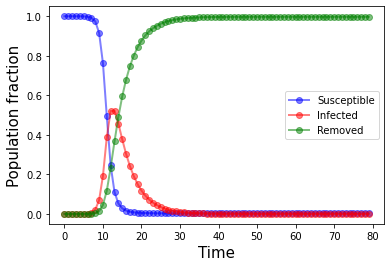

Training
Epoch 0, Loss= 2.77494907, beta= 0.0010, gamma= 0.0007 Time= 0.0031
Epoch 1000, Loss= 0.12959841, beta= 0.0909, gamma= 0.0131 Time= 0.0016
Epoch 2000, Loss= 0.12942007, beta= 0.2695, gamma= 0.0393 Time= 0.0016
Epoch 3000, Loss= 0.12936866, beta= 0.5352, gamma= 0.0786 Time= 0.0015
Epoch 4000, Loss= 0.12932761, beta= 0.8633, gamma= 0.1271 Time= 0.0021
Epoch 5000, Loss= 0.12930126, beta= 1.1990, gamma= 0.1767 Time= 0.0023
Epoch 6000, Loss= 0.12928945, beta= 1.4727, gamma= 0.2169 Time= 0.0021
Epoch 7000, Loss= 0.12928654, beta= 1.6338, gamma= 0.2406 Time= 0.0023
Epoch 8000, Loss= 0.12928544, beta= 1.6890, gamma= 0.2487 Time= 0.0023
Epoch 9000, Loss= 0.12928593, beta= 1.6967, gamma= 0.2498 Time= 0.0019
Epoch 10000, Loss= 0.12928516, beta= 1.6969, gamma= 0.2498 Time= 0.0017
Epoch 11000, Loss= 0.12928510, beta= 1.6972, gamma= 0.2499 Time= 0.0020
Epoch 12000, Loss= 0.12928516, beta= 1.6951, gamma= 0.2495 Time= 0.0017
Epoch 13000, Loss= 0.12928715, beta= 1.6956, gamma= 0.2499 Time= 0.0

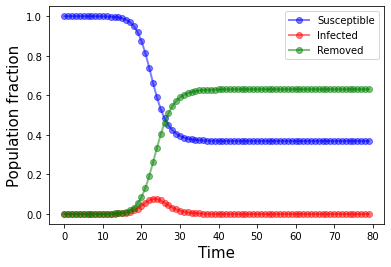

Training
Epoch 0, Loss= 41.02183151, beta= 0.0010, gamma= 0.0009 Time= 0.0020
Epoch 1000, Loss= 0.07301360, beta= 0.0088, gamma= 0.0020 Time= 0.0016
Epoch 2000, Loss= 0.07278944, beta= 0.0186, gamma= 0.0025 Time= 0.0016
Epoch 3000, Loss= 0.07275052, beta= 0.0363, gamma= 0.0040 Time= 0.0016
Epoch 4000, Loss= 0.07274300, beta= 0.0659, gamma= 0.0086 Time= 0.0015
Epoch 5000, Loss= 0.07273682, beta= 0.1138, gamma= 0.0211 Time= 0.0017
Epoch 6000, Loss= 0.07272948, beta= 0.1898, gamma= 0.0509 Time= 0.0018
Epoch 7000, Loss= 0.07271989, beta= 0.3069, gamma= 0.1117 Time= 0.0017
Epoch 8000, Loss= 0.07270776, beta= 0.4787, gamma= 0.2142 Time= 0.0016
Epoch 9000, Loss= 0.07269727, beta= 0.7066, gamma= 0.3543 Time= 0.0015
Epoch 10000, Loss= 0.07268627, beta= 0.9195, gamma= 0.4983 Time= 0.0016
Epoch 11000, Loss= 0.07268308, beta= 1.0680, gamma= 0.5945 Time= 0.0017
Epoch 12000, Loss= 0.07268161, beta= 1.1570, gamma= 0.6587 Time= 0.0015
Epoch 13000, Loss= 0.07271746, beta= 1.2059, gamma= 0.6868 Time= 0.

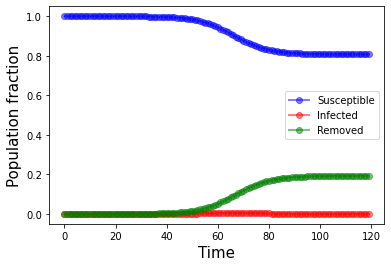

Training
Epoch 0, Loss= 6.80031109, beta= 0.0010, gamma= -0.0009 Time= 0.0036
Epoch 1000, Loss= 0.00747526, beta= 0.0024, gamma= 0.0018 Time= 0.0022
Epoch 2000, Loss= 0.00715766, beta= 0.0064, gamma= 0.0040 Time= 0.0020
Epoch 3000, Loss= 0.00710034, beta= 0.0146, gamma= 0.0076 Time= 0.0030
Epoch 4000, Loss= 0.00708430, beta= 0.0295, gamma= 0.0132 Time= 0.0020
Epoch 5000, Loss= 0.00707916, beta= 0.0551, gamma= 0.0226 Time= 0.0019
Epoch 6000, Loss= 0.00707682, beta= 0.0979, gamma= 0.0414 Time= 0.0026
Epoch 7000, Loss= 0.00707584, beta= 0.1347, gamma= 0.1100 Time= 0.0023
Epoch 8000, Loss= 0.00707520, beta= 0.1791, gamma= 0.1623 Time= 0.0026
Epoch 9000, Loss= 0.00707746, beta= 0.2534, gamma= 0.2266 Time= 0.0020
Epoch 10000, Loss= 0.00707414, beta= 0.3155, gamma= 0.2795 Time= 0.0022
Epoch 11000, Loss= 0.00707360, beta= 0.3539, gamma= 0.3157 Time= 0.0023
Epoch 12000, Loss= 0.00707329, beta= 0.3892, gamma= 0.3612 Time= 0.0030
Epoch 13000, Loss= 0.00707578, beta= 0.3878, gamma= 0.3593 Time= 0.

In [22]:
param_list = [[0.3, 0.1], [0.25, 0.1], [0.3, 0.2] ,  [0.2, 0.1], [0.8, 0.25], [0.8, 0.45], [1.2, 0.25], [1.2, 0.45], [1.2, 0.95], [1.5, 0.25], [1.5, 0.95], [1.5, 1.35]]

t_max_ = [250, 250, 250, 250, 120, 120, 80, 80, 80, 80, 80, 120 ]

layers = [3, 20, 20]

beta_model_ = []
gamma_model_ = []
beta_data_ = []
gamma_data_ = []

for j in range(len(param_list)):

    beta = param_list[j][0]
    gamma = param_list[j][1]

    beta_data_.append(beta)
    gamma_data_.append(gamma)

    print('SIR parameters:')
    print('beta = ', beta)
    print('gamma = ', gamma)

    s, i, t = data_SIR(beta, gamma, t_max= t_max_[j])

    print('Training')
    beta_model, gamma_model = train(s, i, t, layers)

    beta_model_.append(beta_model)
    gamma_model_.append(gamma_model)

    print('-----------')

    print('beta_expected= %.4f, beta_discovered= %.4f' % (beta, beta_model))
    print('gamma_expected= %.4f, gamma_discovered= %.4f' % (gamma, gamma_model))
 
    print('  ')
    print('  ')
    print('  ')

SIR parameters:
beta =  0.3
gamma =  0.1


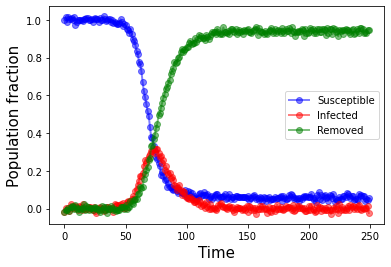

Training
Epoch 0, Loss= 22.12933540, beta= 0.0010, gamma= 0.0010 Time= 0.6216
Epoch 1000, Loss= 0.16220649, beta= 0.0091, gamma= 0.0029 Time= 0.0033
Epoch 2000, Loss= 0.16214353, beta= 0.0222, gamma= 0.0067 Time= 0.0039
Epoch 3000, Loss= 0.16211450, beta= 0.0442, gamma= 0.0138 Time= 0.0036
Epoch 4000, Loss= 0.16209689, beta= 0.0777, gamma= 0.0246 Time= 0.0033
Epoch 5000, Loss= 0.16208427, beta= 0.1244, gamma= 0.0398 Time= 0.0035
Epoch 6000, Loss= 0.16208012, beta= 0.1817, gamma= 0.0583 Time= 0.0034
Epoch 7000, Loss= 0.16207774, beta= 0.2399, gamma= 0.0772 Time= 0.0036
Epoch 8000, Loss= 0.16207673, beta= 0.2835, gamma= 0.0913 Time= 0.0049
Epoch 9000, Loss= 0.16207613, beta= 0.3036, gamma= 0.0978 Time= 0.0036
Epoch 10000, Loss= 0.16207589, beta= 0.3078, gamma= 0.0992 Time= 0.0036
Epoch 11000, Loss= 0.16207574, beta= 0.3078, gamma= 0.0992 Time= 0.0035
Epoch 12000, Loss= 0.16207568, beta= 0.3078, gamma= 0.0992 Time= 0.0041
Epoch 13000, Loss= 0.16207559, beta= 0.3075, gamma= 0.0992 Time= 0.

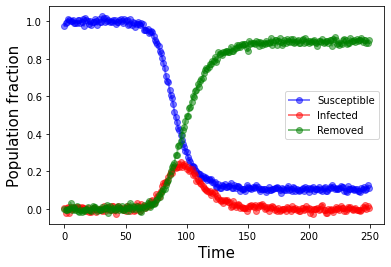

Training
Epoch 0, Loss= 17.62180901, beta= 0.0010, gamma= 0.0010 Time= 0.0052
Epoch 1000, Loss= 0.16339016, beta= 0.0237, gamma= 0.0083 Time= 0.0041
Epoch 2000, Loss= 0.16331320, beta= 0.0627, gamma= 0.0254 Time= 0.0037
Epoch 3000, Loss= 0.16329753, beta= 0.1148, gamma= 0.0483 Time= 0.0035
Epoch 4000, Loss= 0.16328907, beta= 0.1678, gamma= 0.0718 Time= 0.0040
Epoch 5000, Loss= 0.16328494, beta= 0.2061, gamma= 0.0887 Time= 0.0037
Epoch 6000, Loss= 0.16328289, beta= 0.2226, gamma= 0.0959 Time= 0.0035
Epoch 7000, Loss= 0.16328168, beta= 0.2258, gamma= 0.0974 Time= 0.0036
Epoch 8000, Loss= 0.16328092, beta= 0.2260, gamma= 0.0975 Time= 0.0035
Epoch 9000, Loss= 0.16328041, beta= 0.2260, gamma= 0.0974 Time= 0.0036
Epoch 10000, Loss= 0.16328017, beta= 0.2260, gamma= 0.0974 Time= 0.0039
Epoch 11000, Loss= 0.16328008, beta= 0.2262, gamma= 0.0975 Time= 0.0047
Epoch 12000, Loss= 0.16328010, beta= 0.2263, gamma= 0.0976 Time= 0.0042
Epoch 13000, Loss= 0.16328003, beta= 0.2263, gamma= 0.0976 Time= 0.

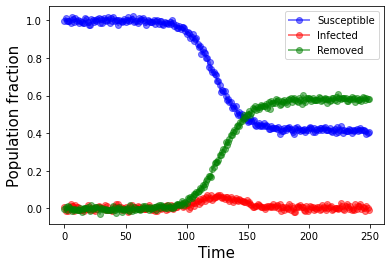

Training
Epoch 0, Loss= 10.24862003, beta= 0.0010, gamma= 0.0010 Time= 0.0052
Epoch 1000, Loss= 0.07081445, beta= 0.0364, gamma= 0.0075 Time= 0.0035
Epoch 2000, Loss= 0.07074723, beta= 0.0962, gamma= 0.0314 Time= 0.0035
Epoch 3000, Loss= 0.07074030, beta= 0.1545, gamma= 0.0784 Time= 0.0036
Epoch 4000, Loss= 0.07073852, beta= 0.2058, gamma= 0.1314 Time= 0.0052
Epoch 5000, Loss= 0.07073802, beta= 0.2419, gamma= 0.1697 Time= 0.0038
Epoch 6000, Loss= 0.07073773, beta= 0.2574, gamma= 0.1861 Time= 0.0034
Epoch 7000, Loss= 0.07074676, beta= 0.2604, gamma= 0.1892 Time= 0.0036
Epoch 8000, Loss= 0.07073767, beta= 0.2606, gamma= 0.1894 Time= 0.0035
Epoch 9000, Loss= 0.07073764, beta= 0.2606, gamma= 0.1894 Time= 0.0035
Epoch 10000, Loss= 0.07073761, beta= 0.2604, gamma= 0.1892 Time= 0.0035
Epoch 11000, Loss= 0.07073759, beta= 0.2597, gamma= 0.1886 Time= 0.0039
Epoch 12000, Loss= 0.07073758, beta= 0.2606, gamma= 0.1895 Time= 0.0036
Epoch 13000, Loss= 0.07074325, beta= 0.2526, gamma= 0.1818 Time= 0.

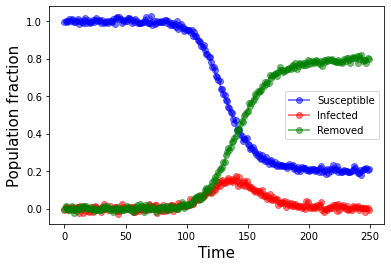

Training
Epoch 0, Loss= 21.38274384, beta= -0.0010, gamma= 0.0010 Time= 0.0052
Epoch 1000, Loss= 0.13096184, beta= 0.0112, gamma= 0.0017 Time= 0.0036
Epoch 2000, Loss= 0.13087234, beta= 0.0372, gamma= 0.0157 Time= 0.0036
Epoch 3000, Loss= 0.13083458, beta= 0.0718, gamma= 0.0392 Time= 0.0041
Epoch 4000, Loss= 0.13081567, beta= 0.1087, gamma= 0.0649 Time= 0.0035
Epoch 5000, Loss= 0.13080737, beta= 0.1375, gamma= 0.0850 Time= 0.0035
Epoch 6000, Loss= 0.13080315, beta= 0.1515, gamma= 0.0947 Time= 0.0036
Epoch 7000, Loss= 0.13080063, beta= 0.1548, gamma= 0.0970 Time= 0.0036
Epoch 8000, Loss= 0.13079910, beta= 0.1551, gamma= 0.0972 Time= 0.0037
Epoch 9000, Loss= 0.13079803, beta= 0.1552, gamma= 0.0973 Time= 0.0035
Epoch 10000, Loss= 0.13079734, beta= 0.1552, gamma= 0.0973 Time= 0.0035
Epoch 11000, Loss= 0.13079685, beta= 0.1553, gamma= 0.0973 Time= 0.0036
Epoch 12000, Loss= 0.13079824, beta= 0.1541, gamma= 0.0965 Time= 0.0035
Epoch 13000, Loss= 0.13079634, beta= 0.1553, gamma= 0.0974 Time= 0

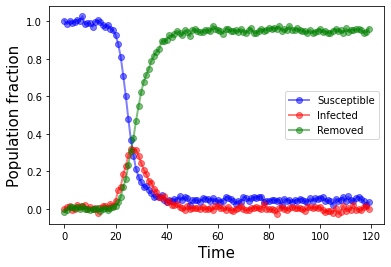

Training
Epoch 0, Loss= 9.37666607, beta= -0.0010, gamma= 0.0010 Time= 0.0024
Epoch 1000, Loss= 0.14140524, beta= 0.0459, gamma= 0.0089 Time= 0.0019
Epoch 2000, Loss= 0.14084764, beta= 0.1549, gamma= 0.0353 Time= 0.0021
Epoch 3000, Loss= 0.14079753, beta= 0.3195, gamma= 0.0770 Time= 0.0019
Epoch 4000, Loss= 0.14077003, beta= 0.5234, gamma= 0.1289 Time= 0.0019
Epoch 5000, Loss= 0.14075410, beta= 0.7279, gamma= 0.1808 Time= 0.0019
Epoch 6000, Loss= 0.14074895, beta= 0.8797, gamma= 0.2193 Time= 0.0019
Epoch 7000, Loss= 0.14074779, beta= 0.9510, gamma= 0.2374 Time= 0.0019
Epoch 8000, Loss= 0.14074853, beta= 0.9657, gamma= 0.2417 Time= 0.0020
Epoch 9000, Loss= 0.14074726, beta= 0.9731, gamma= 0.2430 Time= 0.0019
Epoch 10000, Loss= 0.14074712, beta= 0.9755, gamma= 0.2436 Time= 0.0028
Epoch 11000, Loss= 0.14074703, beta= 0.9736, gamma= 0.2431 Time= 0.0020
Epoch 12000, Loss= 0.14074698, beta= 0.9752, gamma= 0.2436 Time= 0.0021
Epoch 13000, Loss= 0.14103512, beta= 0.9771, gamma= 0.2420 Time= 0.

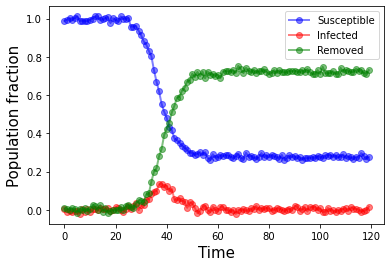

Training
Epoch 0, Loss= 0.95349675, beta= -0.0010, gamma= 0.0010 Time= 0.0035
Epoch 1000, Loss= 0.09854383, beta= 0.1692, gamma= 0.0615 Time= 0.0019
Epoch 2000, Loss= 0.09850612, beta= 0.4420, gamma= 0.2050 Time= 0.0019
Epoch 3000, Loss= 0.09849854, beta= 0.6681, gamma= 0.3240 Time= 0.0020
Epoch 4000, Loss= 0.09849689, beta= 0.7894, gamma= 0.3875 Time= 0.0019
Epoch 5000, Loss= 0.09849642, beta= 0.8272, gamma= 0.4072 Time= 0.0019
Epoch 6000, Loss= 0.09849592, beta= 0.8288, gamma= 0.4079 Time= 0.0020
Epoch 7000, Loss= 0.09849535, beta= 0.8297, gamma= 0.4084 Time= 0.0019
Epoch 8000, Loss= 0.09849463, beta= 0.8273, gamma= 0.4070 Time= 0.0019
Epoch 9000, Loss= 0.09849501, beta= 0.8292, gamma= 0.4091 Time= 0.0019
Epoch 10000, Loss= 0.09849445, beta= 0.8310, gamma= 0.4095 Time= 0.0020
Epoch 11000, Loss= 0.09849273, beta= 0.8345, gamma= 0.4109 Time= 0.0020
Epoch 12000, Loss= 0.09849813, beta= 0.8282, gamma= 0.4108 Time= 0.0019
Epoch 13000, Loss= 0.09849238, beta= 0.8333, gamma= 0.4102 Time= 0.

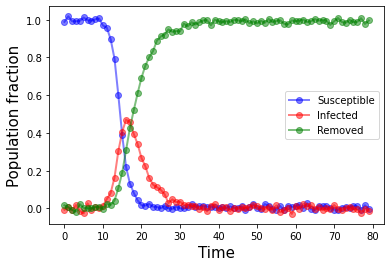

Training
Epoch 0, Loss= 1.34407866, beta= -0.0010, gamma= 0.0010 Time= 0.0027
Epoch 1000, Loss= 0.15146017, beta= 0.6008, gamma= 0.1187 Time= 0.0016
Epoch 2000, Loss= 0.15132791, beta= 1.0528, gamma= 0.2060 Time= 0.0016
Epoch 3000, Loss= 0.15130159, beta= 1.2368, gamma= 0.2413 Time= 0.0015
Epoch 4000, Loss= 0.15129399, beta= 1.2719, gamma= 0.2479 Time= 0.0016
Epoch 5000, Loss= 0.15129019, beta= 1.2754, gamma= 0.2485 Time= 0.0015
Epoch 6000, Loss= 0.15128790, beta= 1.2757, gamma= 0.2485 Time= 0.0016
Epoch 7000, Loss= 0.15129797, beta= 1.2742, gamma= 0.2488 Time= 0.0015
Epoch 8000, Loss= 0.15128684, beta= 1.2764, gamma= 0.2486 Time= 0.0016
Epoch 9000, Loss= 0.15128678, beta= 1.2769, gamma= 0.2488 Time= 0.0015
Epoch 10000, Loss= 0.15128675, beta= 1.2769, gamma= 0.2488 Time= 0.0021
Epoch 11000, Loss= 0.15128674, beta= 1.2757, gamma= 0.2485 Time= 0.0017
Epoch 12000, Loss= 0.15128672, beta= 1.2770, gamma= 0.2488 Time= 0.0018
Epoch 13000, Loss= 0.15128671, beta= 1.2770, gamma= 0.2488 Time= 0.

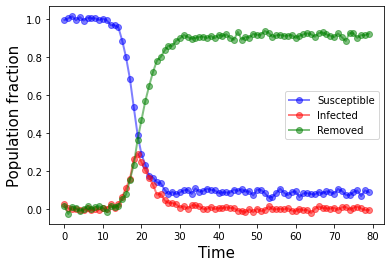

Training
Epoch 0, Loss= 9.80173397, beta= -0.0010, gamma= 0.0010 Time= 0.0023
Epoch 1000, Loss= 0.13709158, beta= 0.2744, gamma= 0.0809 Time= 0.0017
Epoch 2000, Loss= 0.13694744, beta= 0.7278, gamma= 0.2247 Time= 0.0021
Epoch 3000, Loss= 0.13691522, beta= 1.1101, gamma= 0.3446 Time= 0.0016
Epoch 4000, Loss= 0.13690761, beta= 1.3420, gamma= 0.4169 Time= 0.0015
Epoch 5000, Loss= 0.13690600, beta= 1.4349, gamma= 0.4458 Time= 0.0015
Epoch 6000, Loss= 0.13690533, beta= 1.4537, gamma= 0.4517 Time= 0.0015
Epoch 7000, Loss= 0.13690472, beta= 1.4559, gamma= 0.4523 Time= 0.0015
Epoch 8000, Loss= 0.13690427, beta= 1.4567, gamma= 0.4526 Time= 0.0018
Epoch 9000, Loss= 0.13690393, beta= 1.4553, gamma= 0.4522 Time= 0.0015
Epoch 10000, Loss= 0.13690370, beta= 1.4573, gamma= 0.4528 Time= 0.0016
Epoch 11000, Loss= 0.13690360, beta= 1.4552, gamma= 0.4521 Time= 0.0015
Epoch 12000, Loss= 0.13690346, beta= 1.4571, gamma= 0.4527 Time= 0.0015
Epoch 13000, Loss= 0.13690341, beta= 1.4579, gamma= 0.4530 Time= 0.

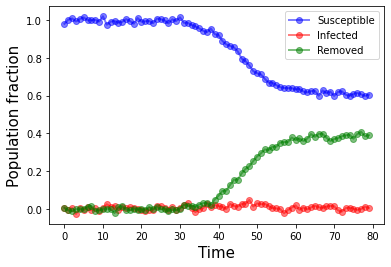

Training
Epoch 0, Loss= 9.65762520, beta= 0.0010, gamma= 0.0010 Time= 0.0025
Epoch 1000, Loss= 0.02943640, beta= 0.0191, gamma= 0.0091 Time= 0.0015
Epoch 2000, Loss= 0.02912067, beta= 0.0519, gamma= 0.0305 Time= 0.0016
Epoch 3000, Loss= 0.02897319, beta= 0.1071, gamma= 0.0650 Time= 0.0015
Epoch 4000, Loss= 0.02891705, beta= 0.2080, gamma= 0.1228 Time= 0.0016
Epoch 5000, Loss= 0.02890154, beta= 0.3373, gamma= 0.2312 Time= 0.0015
Epoch 6000, Loss= 0.02888889, beta= 0.4829, gamma= 0.3668 Time= 0.0015
Epoch 7000, Loss= 0.02887975, beta= 0.6276, gamma= 0.5019 Time= 0.0015
Epoch 8000, Loss= 0.02887456, beta= 0.7492, gamma= 0.6169 Time= 0.0016
Epoch 9000, Loss= 0.02887233, beta= 0.8293, gamma= 0.6915 Time= 0.0015
Epoch 10000, Loss= 0.02887160, beta= 0.8451, gamma= 0.7100 Time= 0.0015
Epoch 11000, Loss= 0.02887118, beta= 0.8686, gamma= 0.7242 Time= 0.0015
Epoch 12000, Loss= 0.02887098, beta= 0.8664, gamma= 0.7233 Time= 0.0016
Epoch 13000, Loss= 0.02888193, beta= 0.8748, gamma= 0.7316 Time= 0.0

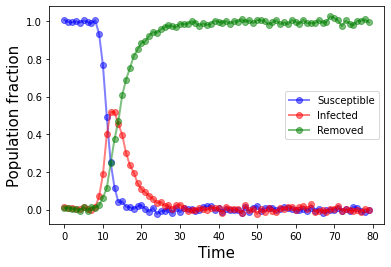

Training
Epoch 0, Loss= 5.00529861, beta= -0.0010, gamma= 0.0010 Time= 0.0030
Epoch 1000, Loss= 0.13156669, beta= 0.1946, gamma= 0.0313 Time= 0.0015
Epoch 2000, Loss= 0.13136758, beta= 0.5774, gamma= 0.0875 Time= 0.0015
Epoch 3000, Loss= 0.13129328, beta= 1.0041, gamma= 0.1503 Time= 0.0017
Epoch 4000, Loss= 0.13126278, beta= 1.3683, gamma= 0.2037 Time= 0.0016
Epoch 5000, Loss= 0.13125370, beta= 1.6002, gamma= 0.2376 Time= 0.0016
Epoch 6000, Loss= 0.13125078, beta= 1.6936, gamma= 0.2513 Time= 0.0017
Epoch 7000, Loss= 0.13124937, beta= 1.7091, gamma= 0.2535 Time= 0.0015
Epoch 8000, Loss= 0.13124844, beta= 1.7097, gamma= 0.2536 Time= 0.0016
Epoch 9000, Loss= 0.13128114, beta= 1.7111, gamma= 0.2530 Time= 0.0015
Epoch 10000, Loss= 0.13124758, beta= 1.7097, gamma= 0.2536 Time= 0.0015
Epoch 11000, Loss= 0.13125004, beta= 1.7070, gamma= 0.2534 Time= 0.0015
Epoch 12000, Loss= 0.13124976, beta= 1.7104, gamma= 0.2538 Time= 0.0016
Epoch 13000, Loss= 0.13124911, beta= 1.7108, gamma= 0.2538 Time= 0.

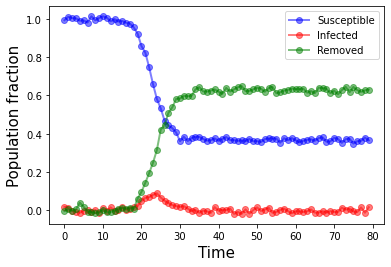

Training
Epoch 0, Loss= 2.66761398, beta= -0.0010, gamma= -0.0010 Time= 0.0029
Epoch 1000, Loss= 0.07398352, beta= 0.0421, gamma= 0.0194 Time= 0.0019
Epoch 2000, Loss= 0.07367744, beta= 0.1754, gamma= 0.0836 Time= 0.0021
Epoch 3000, Loss= 0.07363560, beta= 0.4028, gamma= 0.2110 Time= 0.0034
Epoch 4000, Loss= 0.07361806, beta= 0.7072, gamma= 0.3836 Time= 0.0017
Epoch 5000, Loss= 0.07360663, beta= 1.0255, gamma= 0.5630 Time= 0.0017
Epoch 6000, Loss= 0.07360090, beta= 1.2834, gamma= 0.7077 Time= 0.0015
Epoch 7000, Loss= 0.07359850, beta= 1.4480, gamma= 0.7996 Time= 0.0023
Epoch 8000, Loss= 0.07359735, beta= 1.5448, gamma= 0.8544 Time= 0.0016
Epoch 9000, Loss= 0.07359727, beta= 1.5774, gamma= 0.8718 Time= 0.0015
Epoch 10000, Loss= 0.07363128, beta= 1.6147, gamma= 0.8993 Time= 0.0016
Epoch 11000, Loss= 0.07359633, beta= 1.6210, gamma= 0.8972 Time= 0.0016
Epoch 12000, Loss= 0.07359616, beta= 1.6379, gamma= 0.9065 Time= 0.0015
Epoch 13000, Loss= 0.07359610, beta= 1.6358, gamma= 0.9053 Time= 0

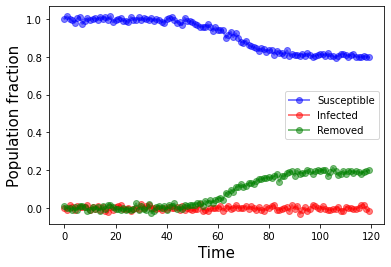

Training
Epoch 0, Loss= 18.06303978, beta= -0.0010, gamma= 0.0010 Time= 0.0035
Epoch 1000, Loss= 0.00766164, beta= -0.0011, gamma= -0.0007 Time= 0.0019
Epoch 2000, Loss= 0.00756257, beta= -0.0013, gamma= -0.0008 Time= 0.0020
Epoch 3000, Loss= 0.00755021, beta= -0.0016, gamma= -0.0010 Time= 0.0020
Epoch 4000, Loss= 0.00754399, beta= -0.0022, gamma= -0.0012 Time= 0.0020
Epoch 5000, Loss= 0.00754077, beta= -0.0031, gamma= -0.0016 Time= 0.0019
Epoch 6000, Loss= 0.00753897, beta= -0.0048, gamma= -0.0024 Time= 0.0019
Epoch 7000, Loss= 0.00753784, beta= -0.0075, gamma= -0.0036 Time= 0.0020
Epoch 8000, Loss= 0.00753710, beta= -0.0120, gamma= -0.0060 Time= 0.0019
Epoch 9000, Loss= 0.00771753, beta= -0.0190, gamma= -0.0107 Time= 0.0019
Epoch 10000, Loss= 0.00753645, beta= -0.0276, gamma= -0.0210 Time= 0.0019
Epoch 11000, Loss= 0.00753798, beta= -0.0383, gamma= -0.0345 Time= 0.0027
Epoch 12000, Loss= 0.00754252, beta= -0.0508, gamma= -0.0480 Time= 0.0019
Epoch 13000, Loss= 0.00753615, beta= -0.05

In [16]:
param_list = [[0.3, 0.1], [0.25, 0.1], [0.3, 0.2] ,  [0.2, 0.1], [0.8, 0.25], [0.8, 0.45], [1.2, 0.25], [1.2, 0.45], [1.2, 0.95], [1.5, 0.25], [1.5, 0.95], [1.5, 1.35]]

t_max_ = [250, 250, 250, 250, 120, 120, 80, 80, 80, 80, 80, 120 ]

layers = [3, 20, 20]

noise_level = 0.01

beta_model_ = []
gamma_model_ = []
beta_data_ = []
gamma_data_ = []

for j in range(len(param_list)):

    beta = param_list[j][0]
    gamma = param_list[j][1]

    beta_data_.append(beta)
    gamma_data_.append(gamma)

    print('SIR parameters:')
    print('beta = ', beta)
    print('gamma = ', gamma)

    s, i, t = data_SIR(beta, gamma, t_max= t_max_[j], noisy= True, noise_level= noise_level)

    print('Training')
    beta_model, gamma_model = train(s, i, t, layers)

    beta_model_.append(beta_model)
    gamma_model_.append(gamma_model)

    print('-----------')

    print('beta_expected= %.4f, beta_discovered= %.4f' % (beta, beta_model))
    print('gamma_expected= %.4f, gamma_discovered= %.4f' % (gamma, gamma_model))
 
    print('  ')
    print('  ')
    print('  ')

SIR parameters:
beta =  0.3
gamma =  0.1


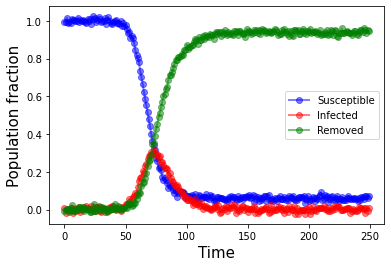

Training
Epoch 0, Loss= 2.28241992, beta= -0.0010, gamma= 0.0010 Time= 0.0045
Epoch 1000, Loss= 0.16141917, beta= 0.1931, gamma= 0.0619 Time= 0.0038
Epoch 2000, Loss= 0.16129835, beta= 0.2929, gamma= 0.0940 Time= 0.0073
Epoch 3000, Loss= 0.16127983, beta= 0.3001, gamma= 0.0962 Time= 0.0043
Epoch 4000, Loss= 0.16127868, beta= 0.3002, gamma= 0.0962 Time= 0.0043
Epoch 5000, Loss= 0.16127840, beta= 0.3003, gamma= 0.0962 Time= 0.0067
Epoch 6000, Loss= 0.16127820, beta= 0.3003, gamma= 0.0962 Time= 0.0050
Epoch 7000, Loss= 0.16127822, beta= 0.3003, gamma= 0.0962 Time= 0.0042
Epoch 8000, Loss= 0.16127813, beta= 0.3003, gamma= 0.0962 Time= 0.0047
Epoch 9000, Loss= 0.16127810, beta= 0.3003, gamma= 0.0962 Time= 0.0038
Epoch 10000, Loss= 0.16127816, beta= 0.3003, gamma= 0.0962 Time= 0.0038
Epoch 11000, Loss= 0.16127823, beta= 0.3002, gamma= 0.0962 Time= 0.0039
Epoch 12000, Loss= 0.16127811, beta= 0.3003, gamma= 0.0962 Time= 0.0037
Epoch 13000, Loss= 0.16127808, beta= 0.3003, gamma= 0.0962 Time= 0.

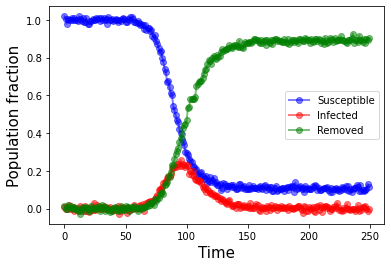

Training
Epoch 0, Loss= 5.00119972, beta= 0.0010, gamma= -0.0010 Time= 0.0047
Epoch 1000, Loss= 0.16389103, beta= 0.1402, gamma= 0.0514 Time= 0.0037
Epoch 2000, Loss= 0.16361313, beta= 0.2046, gamma= 0.0878 Time= 0.0040
Epoch 3000, Loss= 0.16340657, beta= 0.2211, gamma= 0.0960 Time= 0.0042
Epoch 4000, Loss= 0.16336901, beta= 0.2170, gamma= 0.0975 Time= 0.0043
Epoch 5000, Loss= 0.16334878, beta= 0.2254, gamma= 0.0980 Time= 0.0038
Epoch 6000, Loss= 0.16334677, beta= 0.2281, gamma= 0.0995 Time= 0.0037
Epoch 7000, Loss= 0.16335504, beta= 0.2169, gamma= 0.0945 Time= 0.0037
Epoch 8000, Loss= 0.16334598, beta= 0.2280, gamma= 0.0995 Time= 0.0038
Epoch 9000, Loss= 0.16337325, beta= 0.2100, gamma= 0.0907 Time= 0.0045
Epoch 10000, Loss= 0.16334465, beta= 0.2296, gamma= 0.1002 Time= 0.0041
Epoch 11000, Loss= 0.16334525, beta= 0.2289, gamma= 0.0999 Time= 0.0037
Epoch 12000, Loss= 0.16334543, beta= 0.2291, gamma= 0.1000 Time= 0.0037
Epoch 13000, Loss= 0.16335103, beta= 0.2239, gamma= 0.0974 Time= 0.

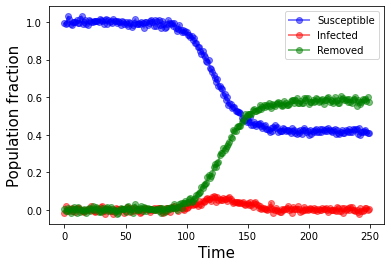

Training
Epoch 0, Loss= 4.10480022, beta= 0.0010, gamma= 0.0010 Time= 0.0044
Epoch 1000, Loss= 0.07128856, beta= 0.0911, gamma= 0.0616 Time= 0.0044
Epoch 2000, Loss= 0.07077847, beta= 0.1911, gamma= 0.1292 Time= 0.0037
Epoch 3000, Loss= 0.07061677, beta= 0.2468, gamma= 0.1676 Time= 0.0037
Epoch 4000, Loss= 0.07052370, beta= 0.2709, gamma= 0.1842 Time= 0.0038
Epoch 5000, Loss= 0.07047659, beta= 0.2818, gamma= 0.1918 Time= 0.0037
Epoch 6000, Loss= 0.07046554, beta= 0.2856, gamma= 0.1942 Time= 0.0037
Epoch 7000, Loss= 0.07048617, beta= 0.2875, gamma= 0.1935 Time= 0.0037
Epoch 8000, Loss= 0.07046025, beta= 0.2903, gamma= 0.1976 Time= 0.0037
Epoch 9000, Loss= 0.07045953, beta= 0.2913, gamma= 0.1983 Time= 0.0037
Epoch 10000, Loss= 0.07047989, beta= 0.2919, gamma= 0.1987 Time= 0.0037
Epoch 11000, Loss= 0.07045884, beta= 0.2922, gamma= 0.1989 Time= 0.0037
Epoch 12000, Loss= 0.07045943, beta= 0.2923, gamma= 0.1990 Time= 0.0037
Epoch 13000, Loss= 0.07045864, beta= 0.2924, gamma= 0.1991 Time= 0.0

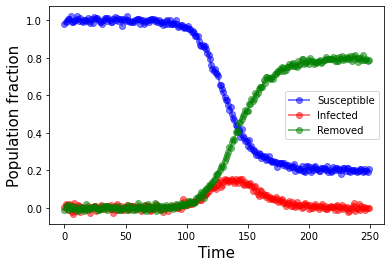

Training
Epoch 0, Loss= 0.63426185, beta= -0.0010, gamma= -0.0010 Time= 0.0042
Epoch 1000, Loss= 0.13052380, beta= 0.1422, gamma= 0.0891 Time= 0.0055
Epoch 2000, Loss= 0.13048770, beta= 0.1534, gamma= 0.0965 Time= 0.0037
Epoch 3000, Loss= 0.13048419, beta= 0.1536, gamma= 0.0966 Time= 0.0037
Epoch 4000, Loss= 0.13048282, beta= 0.1537, gamma= 0.0967 Time= 0.0037
Epoch 5000, Loss= 0.13048233, beta= 0.1538, gamma= 0.0967 Time= 0.0058
Epoch 6000, Loss= 0.13048223, beta= 0.1538, gamma= 0.0967 Time= 0.0037
Epoch 7000, Loss= 0.13048214, beta= 0.1538, gamma= 0.0967 Time= 0.0037
Epoch 8000, Loss= 0.13048212, beta= 0.1537, gamma= 0.0967 Time= 0.0037
Epoch 9000, Loss= 0.13048215, beta= 0.1538, gamma= 0.0967 Time= 0.0037
Epoch 10000, Loss= 0.13048215, beta= 0.1538, gamma= 0.0967 Time= 0.0039
Epoch 11000, Loss= 0.13048217, beta= 0.1538, gamma= 0.0967 Time= 0.0038
Epoch 12000, Loss= 0.13048221, beta= 0.1538, gamma= 0.0967 Time= 0.0041
Epoch 13000, Loss= 0.13048226, beta= 0.1538, gamma= 0.0967 Time= 0

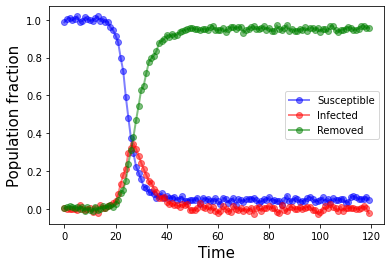

Training
Epoch 0, Loss= 1.99060154, beta= -0.0010, gamma= -0.0010 Time= 0.0026
Epoch 1000, Loss= 0.14228828, beta= 0.0593, gamma= 0.0173 Time= 0.0021
Epoch 2000, Loss= 0.14214490, beta= 0.3753, gamma= 0.0984 Time= 0.0022
Epoch 3000, Loss= 0.14207889, beta= 0.6757, gamma= 0.1756 Time= 0.0021
Epoch 4000, Loss= 0.14205211, beta= 0.8722, gamma= 0.2259 Time= 0.0023
Epoch 5000, Loss= 0.14204237, beta= 0.9503, gamma= 0.2458 Time= 0.0031
Epoch 6000, Loss= 0.14203894, beta= 0.9647, gamma= 0.2495 Time= 0.0021
Epoch 7000, Loss= 0.14203764, beta= 0.9658, gamma= 0.2498 Time= 0.0022
Epoch 8000, Loss= 0.14203712, beta= 0.9661, gamma= 0.2499 Time= 0.0022
Epoch 9000, Loss= 0.14203693, beta= 0.9663, gamma= 0.2500 Time= 0.0021
Epoch 10000, Loss= 0.14203686, beta= 0.9663, gamma= 0.2500 Time= 0.0021
Epoch 11000, Loss= 0.14203684, beta= 0.9664, gamma= 0.2500 Time= 0.0021
Epoch 12000, Loss= 0.14203683, beta= 0.9664, gamma= 0.2500 Time= 0.0022
Epoch 13000, Loss= 0.14203683, beta= 0.9664, gamma= 0.2500 Time= 0

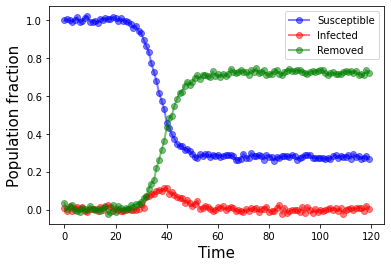

Training
Epoch 0, Loss= 3.35611701, beta= -0.0010, gamma= 0.0010 Time= 0.0037
Epoch 1000, Loss= 0.10203323, beta= 0.0571, gamma= 0.0275 Time= 0.0022
Epoch 2000, Loss= 0.10037693, beta= 0.2034, gamma= 0.1000 Time= 0.0022
Epoch 3000, Loss= 0.09995037, beta= 0.4661, gamma= 0.2317 Time= 0.0021
Epoch 4000, Loss= 0.09986020, beta= 0.7315, gamma= 0.3694 Time= 0.0021
Epoch 5000, Loss= 0.09984826, beta= 0.8637, gamma= 0.4390 Time= 0.0022
Epoch 6000, Loss= 0.09984659, beta= 0.8919, gamma= 0.4538 Time= 0.0021
Epoch 7000, Loss= 0.09984560, beta= 0.8854, gamma= 0.4503 Time= 0.0021
Epoch 8000, Loss= 0.09984456, beta= 0.8799, gamma= 0.4475 Time= 0.0021
Epoch 9000, Loss= 0.09986491, beta= 0.8662, gamma= 0.4412 Time= 0.0021
Epoch 10000, Loss= 0.09984267, beta= 0.8752, gamma= 0.4451 Time= 0.0021
Epoch 11000, Loss= 0.09999453, beta= 0.8868, gamma= 0.4531 Time= 0.0022
Epoch 12000, Loss= 0.09984340, beta= 0.8834, gamma= 0.4496 Time= 0.0021
Epoch 13000, Loss= 0.09984431, beta= 0.8861, gamma= 0.4506 Time= 0.

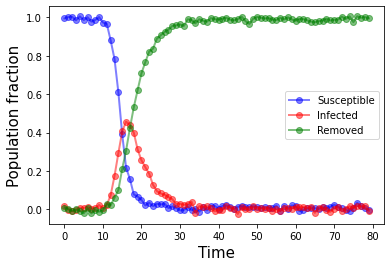

Training
Epoch 0, Loss= 1.46444249, beta= -0.0010, gamma= -0.0010 Time= 0.0031
Epoch 1000, Loss= 0.14859658, beta= 0.0528, gamma= 0.0167 Time= 0.0018
Epoch 2000, Loss= 0.14847265, beta= 0.3007, gamma= 0.0653 Time= 0.0017
Epoch 3000, Loss= 0.14840515, beta= 0.6112, gamma= 0.1262 Time= 0.0019
Epoch 4000, Loss= 0.14837061, beta= 0.9090, gamma= 0.1846 Time= 0.0018
Epoch 5000, Loss= 0.14835897, beta= 1.1219, gamma= 0.2263 Time= 0.0018
Epoch 6000, Loss= 0.14835681, beta= 1.2213, gamma= 0.2457 Time= 0.0018
Epoch 7000, Loss= 0.14835647, beta= 1.2443, gamma= 0.2502 Time= 0.0018
Epoch 8000, Loss= 0.14835644, beta= 1.2461, gamma= 0.2505 Time= 0.0018
Epoch 9000, Loss= 0.14835639, beta= 1.2461, gamma= 0.2505 Time= 0.0018
Epoch 10000, Loss= 0.14835641, beta= 1.2461, gamma= 0.2506 Time= 0.0018
Epoch 11000, Loss= 0.14835636, beta= 1.2461, gamma= 0.2506 Time= 0.0018
Epoch 12000, Loss= 0.14835641, beta= 1.2461, gamma= 0.2506 Time= 0.0018
Epoch 13000, Loss= 0.14835636, beta= 1.2461, gamma= 0.2506 Time= 0

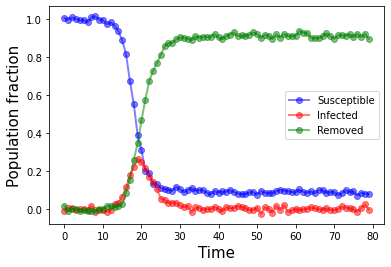

Training
Epoch 0, Loss= 1.39287877, beta= -0.0010, gamma= 0.0010 Time= 0.0021
Epoch 1000, Loss= 0.13610819, beta= 0.0799, gamma= 0.0157 Time= 0.0018
Epoch 2000, Loss= 0.13602386, beta= 0.3396, gamma= 0.0953 Time= 0.0018
Epoch 3000, Loss= 0.13597146, beta= 0.6764, gamma= 0.1985 Time= 0.0018
Epoch 4000, Loss= 0.13594097, beta= 1.0129, gamma= 0.3014 Time= 0.0018
Epoch 5000, Loss= 0.13592857, beta= 1.2772, gamma= 0.3820 Time= 0.0023
Epoch 6000, Loss= 0.13592540, beta= 1.4321, gamma= 0.4291 Time= 0.0018
Epoch 7000, Loss= 0.13592474, beta= 1.4891, gamma= 0.4465 Time= 0.0019
Epoch 8000, Loss= 0.13592470, beta= 1.4987, gamma= 0.4494 Time= 0.0022
Epoch 9000, Loss= 0.13592461, beta= 1.4992, gamma= 0.4495 Time= 0.0018
Epoch 10000, Loss= 0.13592459, beta= 1.4992, gamma= 0.4495 Time= 0.0019
Epoch 11000, Loss= 0.13592459, beta= 1.4993, gamma= 0.4495 Time= 0.0018
Epoch 12000, Loss= 0.13592455, beta= 1.4993, gamma= 0.4495 Time= 0.0023
Epoch 13000, Loss= 0.13592455, beta= 1.4992, gamma= 0.4495 Time= 0.

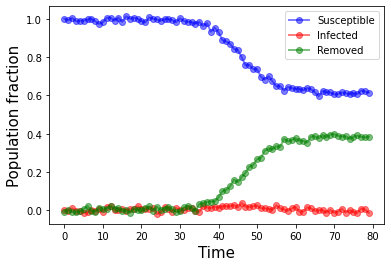

Training
Epoch 0, Loss= 0.59699422, beta= 0.0010, gamma= 0.0010 Time= 0.0033
Epoch 1000, Loss= 0.02953567, beta= 0.0609, gamma= 0.0460 Time= 0.0018
Epoch 2000, Loss= 0.02880963, beta= 0.2584, gamma= 0.2166 Time= 0.0019
Epoch 3000, Loss= 0.02870254, beta= 0.4781, gamma= 0.4131 Time= 0.0019
Epoch 4000, Loss= 0.02864678, beta= 0.7100, gamma= 0.6147 Time= 0.0023
Epoch 5000, Loss= 0.02861852, beta= 0.9006, gamma= 0.7838 Time= 0.0043
Epoch 6000, Loss= 0.02860982, beta= 1.0142, gamma= 0.8852 Time= 0.0019
Epoch 7000, Loss= 0.02860825, beta= 1.0555, gamma= 0.9219 Time= 0.0018
Epoch 8000, Loss= 0.02860735, beta= 1.0726, gamma= 0.9369 Time= 0.0018
Epoch 9000, Loss= 0.02860669, beta= 1.0839, gamma= 0.9468 Time= 0.0018
Epoch 10000, Loss= 0.02860618, beta= 1.0915, gamma= 0.9535 Time= 0.0020
Epoch 11000, Loss= 0.02860613, beta= 1.0969, gamma= 0.9582 Time= 0.0018
Epoch 12000, Loss= 0.02860563, beta= 1.0974, gamma= 0.9586 Time= 0.0018
Epoch 13000, Loss= 0.02860574, beta= 1.0996, gamma= 0.9609 Time= 0.0

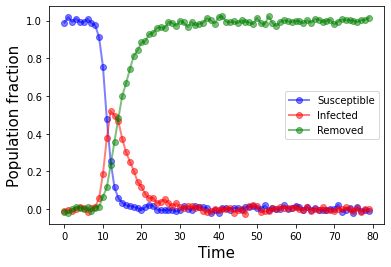

Training
Epoch 0, Loss= 5.33436394, beta= -0.0010, gamma= -0.0010 Time= 0.0034
Epoch 1000, Loss= 0.13459338, beta= -0.0129, gamma= -0.0026 Time= 0.0018
Epoch 2000, Loss= 0.13030478, beta= 0.1315, gamma= 0.0149 Time= 0.0018
Epoch 3000, Loss= 0.12976074, beta= 0.3712, gamma= 0.0506 Time= 0.0018
Epoch 4000, Loss= 0.12956740, beta= 0.6885, gamma= 0.0979 Time= 0.0028
Epoch 5000, Loss= 0.12946445, beta= 1.0430, gamma= 0.1508 Time= 0.0018
Epoch 6000, Loss= 0.12941307, beta= 1.3680, gamma= 0.1990 Time= 0.0018
Epoch 7000, Loss= 0.12939250, beta= 1.5978, gamma= 0.2329 Time= 0.0018
Epoch 8000, Loss= 0.12938458, beta= 1.7062, gamma= 0.2488 Time= 0.0018
Epoch 9000, Loss= 0.12938036, beta= 1.7332, gamma= 0.2528 Time= 0.0018
Epoch 10000, Loss= 0.12937716, beta= 1.7369, gamma= 0.2533 Time= 0.0018
Epoch 11000, Loss= 0.12937577, beta= 1.7380, gamma= 0.2535 Time= 0.0018
Epoch 12000, Loss= 0.12937503, beta= 1.7385, gamma= 0.2535 Time= 0.0018
Epoch 13000, Loss= 0.12937452, beta= 1.7388, gamma= 0.2536 Time=

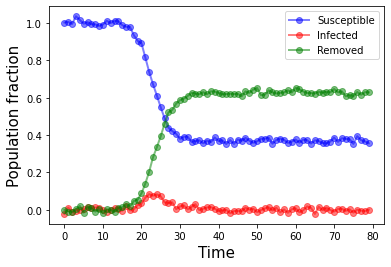

Training
Epoch 0, Loss= 3.93831110, beta= 0.0010, gamma= 0.0010 Time= 0.0032
Epoch 1000, Loss= 0.08263141, beta= -0.0074, gamma= -0.0046 Time= 0.0018
Epoch 2000, Loss= 0.07672849, beta= 0.0889, gamma= 0.0310 Time= 0.0018
Epoch 3000, Loss= 0.07507085, beta= 0.2767, gamma= 0.1312 Time= 0.0018
Epoch 4000, Loss= 0.07457117, beta= 0.5002, gamma= 0.2481 Time= 0.0018
Epoch 5000, Loss= 0.07438602, beta= 0.8026, gamma= 0.4103 Time= 0.0019
Epoch 6000, Loss= 0.07433044, beta= 1.1145, gamma= 0.5841 Time= 0.0018
Epoch 7000, Loss= 0.07431962, beta= 1.3598, gamma= 0.7221 Time= 0.0018
Epoch 8000, Loss= 0.07430889, beta= 1.5141, gamma= 0.8085 Time= 0.0018
Epoch 9000, Loss= 0.07430518, beta= 1.5961, gamma= 0.8539 Time= 0.0018
Epoch 10000, Loss= 0.07430226, beta= 1.6440, gamma= 0.8798 Time= 0.0018
Epoch 11000, Loss= 0.07429978, beta= 1.6936, gamma= 0.9066 Time= 0.0025
Epoch 12000, Loss= 0.07429776, beta= 1.7209, gamma= 0.9211 Time= 0.0020
Epoch 13000, Loss= 0.07432012, beta= 1.7670, gamma= 0.9459 Time= 0

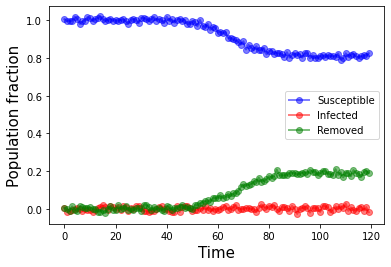

Training
Epoch 0, Loss= 4.35903692, beta= -0.0010, gamma= 0.0010 Time= 0.0043
Epoch 1000, Loss= 0.00784170, beta= 0.0446, gamma= 0.0315 Time= 0.0022
Epoch 2000, Loss= 0.00782882, beta= 0.0913, gamma= 0.0412 Time= 0.0022
Epoch 3000, Loss= 0.00782777, beta= 0.1627, gamma= 0.0642 Time= 0.0022
Epoch 4000, Loss= 0.00782696, beta= 0.2548, gamma= 0.1136 Time= 0.0021
Epoch 5000, Loss= 0.00782626, beta= 0.3582, gamma= 0.2053 Time= 0.0021
Epoch 6000, Loss= 0.00782565, beta= 0.4698, gamma= 0.3448 Time= 0.0022
Epoch 7000, Loss= 0.00782519, beta= 0.5916, gamma= 0.5150 Time= 0.0022
Epoch 8000, Loss= 0.00782493, beta= 0.7149, gamma= 0.6839 Time= 0.0022
Epoch 9000, Loss= 0.00782483, beta= 0.8202, gamma= 0.8234 Time= 0.0021
Epoch 10000, Loss= 0.00782480, beta= 0.8920, gamma= 0.9165 Time= 0.0022
Epoch 11000, Loss= 0.00782479, beta= 0.9268, gamma= 0.9611 Time= 0.0021
Epoch 12000, Loss= 0.00782479, beta= 0.9363, gamma= 0.9732 Time= 0.0021
Epoch 13000, Loss= 0.00782479, beta= 0.9373, gamma= 0.9745 Time= 0.

In [6]:
param_list = [[0.3, 0.1], [0.25, 0.1], [0.3, 0.2] ,  [0.2, 0.1], [0.8, 0.25], [0.8, 0.45], [1.2, 0.25], [1.2, 0.45], [1.2, 0.95], [1.5, 0.25], [1.5, 0.95], [1.5, 1.35]]

t_max_ = [250, 250, 250, 250, 120, 120, 80, 80, 80, 80, 80, 120 ]

layers = [3, 6]

noise_level = 0.01

beta_model_ = []
gamma_model_ = []
beta_data_ = []
gamma_data_ = []

for j in range(len(param_list)):

    beta = param_list[j][0]
    gamma = param_list[j][1]

    beta_data_.append(beta)
    gamma_data_.append(gamma)

    print('SIR parameters:')
    print('beta = ', beta)
    print('gamma = ', gamma)

    s, i, t = data_SIR(beta, gamma, t_max= t_max_[j], noisy= True, noise_level= noise_level)

    print('Training')
    beta_model, gamma_model = train(s, i, t, layers)

    beta_model_.append(beta_model)
    gamma_model_.append(gamma_model)

    print('-----------')

    print('beta_expected= %.4f, beta_discovered= %.4f' % (beta, beta_model))
    print('gamma_expected= %.4f, gamma_discovered= %.4f' % (gamma, gamma_model))
 
    print('  ')
    print('  ')
    print('  ')

SIR parameters:
beta =  0.3
gamma =  0.1


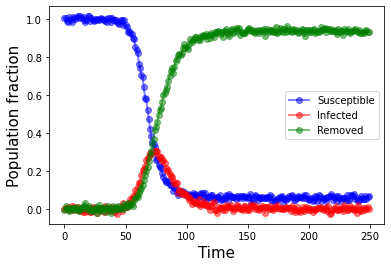

Training
Epoch 0, Loss= 15.55085278, beta= 0.0010, gamma= 0.0010 Time= 0.7621
Epoch 1000, Loss= 0.16416913, beta= 0.0166, gamma= 0.0034 Time= 0.0036
Epoch 2000, Loss= 0.16222531, beta= 0.0511, gamma= 0.0148 Time= 0.0035
Epoch 3000, Loss= 0.16204703, beta= 0.1029, gamma= 0.0320 Time= 0.0038
Epoch 4000, Loss= 0.16196799, beta= 0.1670, gamma= 0.0530 Time= 0.0037
Epoch 5000, Loss= 0.16189781, beta= 0.2317, gamma= 0.0740 Time= 0.0037
Epoch 6000, Loss= 0.16184039, beta= 0.2815, gamma= 0.0900 Time= 0.0036
Epoch 7000, Loss= 0.16181122, beta= 0.3068, gamma= 0.0982 Time= 0.0038
Epoch 8000, Loss= 0.16180396, beta= 0.3126, gamma= 0.1000 Time= 0.0037
Epoch 9000, Loss= 0.16179912, beta= 0.3133, gamma= 0.1002 Time= 0.0038
Epoch 10000, Loss= 0.16179577, beta= 0.3135, gamma= 0.1003 Time= 0.0037
Epoch 11000, Loss= 0.16179346, beta= 0.3137, gamma= 0.1003 Time= 0.0039
Epoch 12000, Loss= 0.16179194, beta= 0.3137, gamma= 0.1003 Time= 0.0038
Epoch 13000, Loss= 0.16179106, beta= 0.3138, gamma= 0.1003 Time= 0.

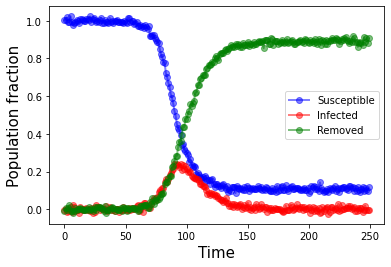

Training
Epoch 0, Loss= 0.89606416, beta= 0.0010, gamma= 0.0010 Time= 0.0044
Epoch 1000, Loss= 0.16357736, beta= 0.2268, gamma= 0.0977 Time= 0.0041
Epoch 2000, Loss= 0.16356823, beta= 0.2281, gamma= 0.0982 Time= 0.0038
Epoch 3000, Loss= 0.16356756, beta= 0.2281, gamma= 0.0982 Time= 0.0038
Epoch 4000, Loss= 0.16356717, beta= 0.2282, gamma= 0.0982 Time= 0.0037
Epoch 5000, Loss= 0.16356680, beta= 0.2282, gamma= 0.0983 Time= 0.0038
Epoch 6000, Loss= 0.16356659, beta= 0.2282, gamma= 0.0983 Time= 0.0038
Epoch 7000, Loss= 0.16356634, beta= 0.2282, gamma= 0.0983 Time= 0.0038
Epoch 8000, Loss= 0.16356628, beta= 0.2282, gamma= 0.0983 Time= 0.0038
Epoch 9000, Loss= 0.16356623, beta= 0.2282, gamma= 0.0983 Time= 0.0038
Epoch 10000, Loss= 0.16356619, beta= 0.2282, gamma= 0.0983 Time= 0.0052
Epoch 11000, Loss= 0.16356619, beta= 0.2282, gamma= 0.0983 Time= 0.0041
Epoch 12000, Loss= 0.16356619, beta= 0.2282, gamma= 0.0983 Time= 0.0039
Epoch 13000, Loss= 0.16356616, beta= 0.2282, gamma= 0.0983 Time= 0.0

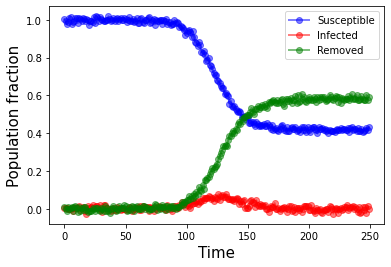

Training
Epoch 0, Loss= 6.07791185, beta= 0.0010, gamma= -0.0010 Time= 0.0052
Epoch 1000, Loss= 0.07259279, beta= -0.0027, gamma= -0.0096 Time= 0.0052
Epoch 2000, Loss= 0.07126950, beta= 0.0317, gamma= 0.0213 Time= 0.0053
Epoch 3000, Loss= 0.07047277, beta= 0.1148, gamma= 0.0596 Time= 0.0052
Epoch 4000, Loss= 0.07044416, beta= 0.2089, gamma= 0.1316 Time= 0.0054
Epoch 5000, Loss= 0.07044069, beta= 0.2535, gamma= 0.1768 Time= 0.0044
Epoch 6000, Loss= 0.07048663, beta= 0.2668, gamma= 0.1899 Time= 0.0041
Epoch 7000, Loss= 0.07043560, beta= 0.2703, gamma= 0.1927 Time= 0.0079
Epoch 8000, Loss= 0.07043344, beta= 0.2733, gamma= 0.1950 Time= 0.0040
Epoch 9000, Loss= 0.07043090, beta= 0.2768, gamma= 0.1974 Time= 0.0072
Epoch 10000, Loss= 0.07042941, beta= 0.2797, gamma= 0.1995 Time= 0.0038
Epoch 11000, Loss= 0.07042885, beta= 0.2810, gamma= 0.2004 Time= 0.0067
Epoch 12000, Loss= 0.07042862, beta= 0.2813, gamma= 0.2006 Time= 0.0039
Epoch 13000, Loss= 0.07042855, beta= 0.2814, gamma= 0.2007 Time= 

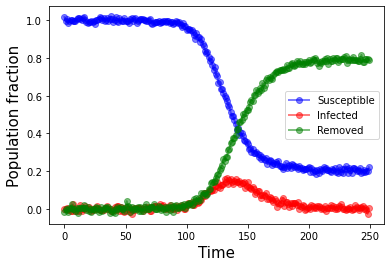

Training
Epoch 0, Loss= 0.71587092, beta= -0.0010, gamma= 0.0010 Time= 0.0061
Epoch 1000, Loss= 0.13052794, beta= 0.1384, gamma= 0.0836 Time= 0.0046
Epoch 2000, Loss= 0.13050200, beta= 0.1567, gamma= 0.0977 Time= 0.0043
Epoch 3000, Loss= 0.13049391, beta= 0.1573, gamma= 0.0982 Time= 0.0037
Epoch 4000, Loss= 0.13048968, beta= 0.1575, gamma= 0.0983 Time= 0.0038
Epoch 5000, Loss= 0.13048717, beta= 0.1576, gamma= 0.0983 Time= 0.0045
Epoch 6000, Loss= 0.13048601, beta= 0.1576, gamma= 0.0984 Time= 0.0041
Epoch 7000, Loss= 0.13049799, beta= 0.1576, gamma= 0.0984 Time= 0.0049
Epoch 8000, Loss= 0.13048558, beta= 0.1576, gamma= 0.0984 Time= 0.0042
Epoch 9000, Loss= 0.13048562, beta= 0.1576, gamma= 0.0984 Time= 0.0074
Epoch 10000, Loss= 0.13048553, beta= 0.1576, gamma= 0.0984 Time= 0.0054
Epoch 11000, Loss= 0.13048553, beta= 0.1576, gamma= 0.0984 Time= 0.0057
Epoch 12000, Loss= 0.13048552, beta= 0.1576, gamma= 0.0984 Time= 0.0048
Epoch 13000, Loss= 0.13048556, beta= 0.1576, gamma= 0.0984 Time= 0.

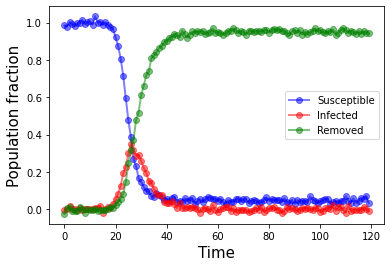

Training
Epoch 0, Loss= 1.55746126, beta= -0.0010, gamma= 0.0010 Time= 0.0040
Epoch 1000, Loss= 0.14270104, beta= 0.4098, gamma= 0.1042 Time= 0.0024
Epoch 2000, Loss= 0.14239158, beta= 0.7933, gamma= 0.2010 Time= 0.0022
Epoch 3000, Loss= 0.14227936, beta= 0.9335, gamma= 0.2354 Time= 0.0023
Epoch 4000, Loss= 0.14225030, beta= 0.9605, gamma= 0.2416 Time= 0.0024
Epoch 5000, Loss= 0.14224495, beta= 0.9659, gamma= 0.2428 Time= 0.0022
Epoch 6000, Loss= 0.14224367, beta= 0.9669, gamma= 0.2431 Time= 0.0023
Epoch 7000, Loss= 0.14224270, beta= 0.9674, gamma= 0.2432 Time= 0.0025
Epoch 8000, Loss= 0.14224242, beta= 0.9672, gamma= 0.2432 Time= 0.0022
Epoch 9000, Loss= 0.14224321, beta= 0.9668, gamma= 0.2431 Time= 0.0022
Epoch 10000, Loss= 0.14224195, beta= 0.9680, gamma= 0.2434 Time= 0.0022
Epoch 11000, Loss= 0.14224184, beta= 0.9683, gamma= 0.2434 Time= 0.0023
Epoch 12000, Loss= 0.14224915, beta= 0.9678, gamma= 0.2430 Time= 0.0025
Epoch 13000, Loss= 0.14224173, beta= 0.9682, gamma= 0.2434 Time= 0.

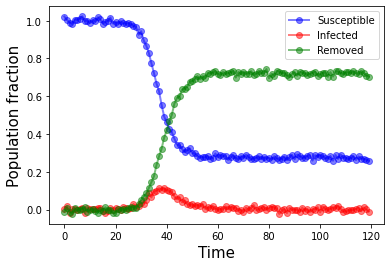

Training
Epoch 0, Loss= 2.93092752, beta= 0.0010, gamma= -0.0010 Time= 0.0040
Epoch 1000, Loss= 0.10127615, beta= 0.0036, gamma= -0.0002 Time= 0.0024
Epoch 2000, Loss= 0.10057181, beta= 0.1560, gamma= 0.0767 Time= 0.0022
Epoch 3000, Loss= 0.10017218, beta= 0.3255, gamma= 0.1639 Time= 0.0023
Epoch 4000, Loss= 0.09993950, beta= 0.5058, gamma= 0.2575 Time= 0.0022
Epoch 5000, Loss= 0.09984681, beta= 0.6735, gamma= 0.3441 Time= 0.0024
Epoch 6000, Loss= 0.09982285, beta= 0.7893, gamma= 0.4038 Time= 0.0026
Epoch 7000, Loss= 0.09981858, beta= 0.8292, gamma= 0.4244 Time= 0.0022
Epoch 8000, Loss= 0.09981777, beta= 0.8353, gamma= 0.4275 Time= 0.0022
Epoch 9000, Loss= 0.09981767, beta= 0.8360, gamma= 0.4279 Time= 0.0022
Epoch 10000, Loss= 0.09981766, beta= 0.8361, gamma= 0.4279 Time= 0.0021
Epoch 11000, Loss= 0.09981766, beta= 0.8362, gamma= 0.4279 Time= 0.0022
Epoch 12000, Loss= 0.09981774, beta= 0.8362, gamma= 0.4279 Time= 0.0022
Epoch 13000, Loss= 0.09981762, beta= 0.8362, gamma= 0.4280 Time= 0

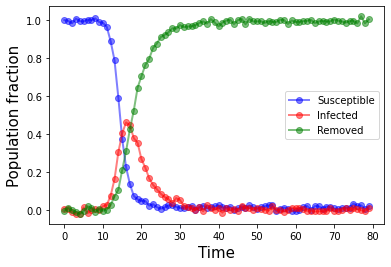

Training
Epoch 0, Loss= 1.22665811, beta= 0.0010, gamma= 0.0010 Time= 0.0023
Epoch 1000, Loss= 0.14882213, beta= 0.2190, gamma= 0.0420 Time= 0.0021
Epoch 2000, Loss= 0.14864556, beta= 0.5397, gamma= 0.1062 Time= 0.0019
Epoch 3000, Loss= 0.14859298, beta= 0.8695, gamma= 0.1716 Time= 0.0022
Epoch 4000, Loss= 0.14857467, beta= 1.1125, gamma= 0.2198 Time= 0.0026
Epoch 5000, Loss= 0.14856975, beta= 1.2299, gamma= 0.2431 Time= 0.0018
Epoch 6000, Loss= 0.14856757, beta= 1.2590, gamma= 0.2488 Time= 0.0019
Epoch 7000, Loss= 0.14856596, beta= 1.2616, gamma= 0.2493 Time= 0.0030
Epoch 8000, Loss= 0.14856476, beta= 1.2618, gamma= 0.2494 Time= 0.0022
Epoch 9000, Loss= 0.14856392, beta= 1.2619, gamma= 0.2494 Time= 0.0020
Epoch 10000, Loss= 0.14856334, beta= 1.2620, gamma= 0.2495 Time= 0.0018
Epoch 11000, Loss= 0.14856301, beta= 1.2620, gamma= 0.2495 Time= 0.0018
Epoch 12000, Loss= 0.14856285, beta= 1.2621, gamma= 0.2495 Time= 0.0022
Epoch 13000, Loss= 0.14856276, beta= 1.2621, gamma= 0.2495 Time= 0.0

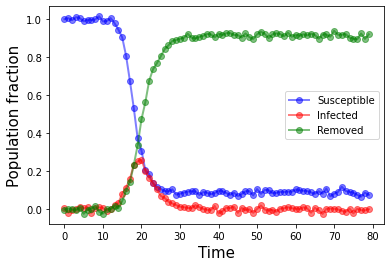

Training
Epoch 0, Loss= 4.05179739, beta= -0.0010, gamma= -0.0010 Time= 0.0022
Epoch 1000, Loss= 0.13826905, beta= -0.0302, gamma= -0.0141 Time= 0.0019
Epoch 2000, Loss= 0.13780670, beta= 0.1031, gamma= 0.0238 Time= 0.0018
Epoch 3000, Loss= 0.13769953, beta= 0.3065, gamma= 0.0858 Time= 0.0018
Epoch 4000, Loss= 0.13760003, beta= 0.5770, gamma= 0.1691 Time= 0.0018
Epoch 5000, Loss= 0.13751791, beta= 0.8853, gamma= 0.2646 Time= 0.0018
Epoch 6000, Loss= 0.13749059, beta= 1.1728, gamma= 0.3530 Time= 0.0018
Epoch 7000, Loss= 0.13748023, beta= 1.3823, gamma= 0.4173 Time= 0.0018
Epoch 8000, Loss= 0.13747706, beta= 1.4908, gamma= 0.4505 Time= 0.0018
Epoch 9000, Loss= 0.13747601, beta= 1.5224, gamma= 0.4602 Time= 0.0018
Epoch 10000, Loss= 0.13747545, beta= 1.5263, gamma= 0.4613 Time= 0.0019
Epoch 11000, Loss= 0.13747503, beta= 1.5269, gamma= 0.4615 Time= 0.0018
Epoch 12000, Loss= 0.13747473, beta= 1.5273, gamma= 0.4616 Time= 0.0018
Epoch 13000, Loss= 0.13747458, beta= 1.5276, gamma= 0.4617 Time=

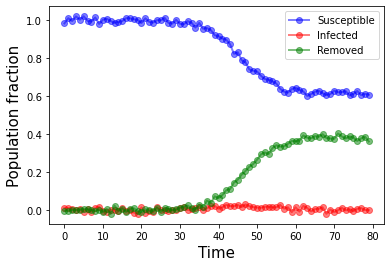

Training
Epoch 0, Loss= 0.39474541, beta= 0.0010, gamma= 0.0010 Time= 0.0036
Epoch 1000, Loss= 0.03010799, beta= 0.0647, gamma= 0.0488 Time= 0.0021
Epoch 2000, Loss= 0.02914216, beta= 0.2065, gamma= 0.1699 Time= 0.0018
Epoch 3000, Loss= 0.02889461, beta= 0.4629, gamma= 0.3962 Time= 0.0018
Epoch 4000, Loss= 0.02884305, beta= 0.7246, gamma= 0.6250 Time= 0.0021
Epoch 5000, Loss= 0.02883944, beta= 0.8088, gamma= 0.6976 Time= 0.0021
Epoch 6000, Loss= 0.02883821, beta= 0.8314, gamma= 0.7170 Time= 0.0018
Epoch 7000, Loss= 0.02883786, beta= 0.8371, gamma= 0.7219 Time= 0.0018
Epoch 8000, Loss= 0.02883776, beta= 0.8379, gamma= 0.7226 Time= 0.0018
Epoch 9000, Loss= 0.02883772, beta= 0.8401, gamma= 0.7245 Time= 0.0019
Epoch 10000, Loss= 0.02883770, beta= 0.8349, gamma= 0.7200 Time= 0.0018
Epoch 11000, Loss= 0.02883763, beta= 0.8436, gamma= 0.7275 Time= 0.0018
Epoch 12000, Loss= 0.02883760, beta= 0.8431, gamma= 0.7271 Time= 0.0018
Epoch 13000, Loss= 0.02883757, beta= 0.8428, gamma= 0.7269 Time= 0.0

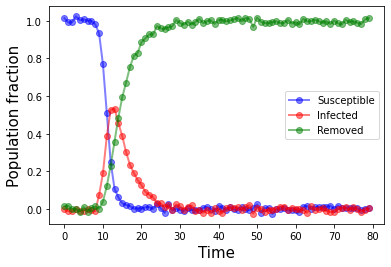

Training
Epoch 0, Loss= 3.79883623, beta= -0.0010, gamma= -0.0010 Time= 0.0032
Epoch 1000, Loss= 0.13792251, beta= 0.0286, gamma= 0.0019 Time= 0.0018
Epoch 2000, Loss= 0.13288893, beta= 0.2212, gamma= 0.0315 Time= 0.0018
Epoch 3000, Loss= 0.13246055, beta= 0.5042, gamma= 0.0728 Time= 0.0018
Epoch 4000, Loss= 0.13232560, beta= 0.8537, gamma= 0.1236 Time= 0.0018
Epoch 5000, Loss= 0.13225111, beta= 1.2138, gamma= 0.1771 Time= 0.0019
Epoch 6000, Loss= 0.13219577, beta= 1.5136, gamma= 0.2223 Time= 0.0018
Epoch 7000, Loss= 0.13215792, beta= 1.6998, gamma= 0.2508 Time= 0.0018
Epoch 8000, Loss= 0.13214071, beta= 1.7717, gamma= 0.2620 Time= 0.0018
Epoch 9000, Loss= 0.13213883, beta= 1.7841, gamma= 0.2639 Time= 0.0018
Epoch 10000, Loss= 0.13213782, beta= 1.7850, gamma= 0.2640 Time= 0.0018
Epoch 11000, Loss= 0.13213816, beta= 1.7853, gamma= 0.2640 Time= 0.0018
Epoch 12000, Loss= 0.13213646, beta= 1.7855, gamma= 0.2641 Time= 0.0018
Epoch 13000, Loss= 0.13213742, beta= 1.7853, gamma= 0.2642 Time= 0

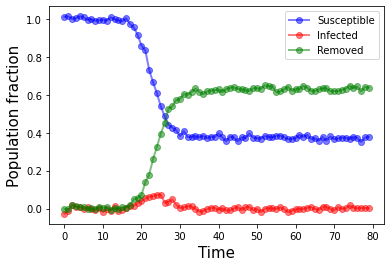

Training
Epoch 0, Loss= 5.33724356, beta= 0.0010, gamma= -0.0010 Time= 0.0036
Epoch 1000, Loss= 0.07478403, beta= 0.0976, gamma= 0.0436 Time= 0.0018
Epoch 2000, Loss= 0.07340916, beta= 0.1189, gamma= 0.0564 Time= 0.0018
Epoch 3000, Loss= 0.07303064, beta= 0.1645, gamma= 0.0705 Time= 0.0018
Epoch 4000, Loss= 0.07284570, beta= 0.2535, gamma= 0.0977 Time= 0.0018
Epoch 5000, Loss= 0.07276281, beta= 0.4103, gamma= 0.1524 Time= 0.0018
Epoch 6000, Loss= 0.07272799, beta= 0.6387, gamma= 0.2636 Time= 0.0018
Epoch 7000, Loss= 0.07270808, beta= 0.9156, gamma= 0.4264 Time= 0.0018
Epoch 8000, Loss= 0.07269295, beta= 1.2121, gamma= 0.6018 Time= 0.0018
Epoch 9000, Loss= 0.07268149, beta= 1.5104, gamma= 0.7727 Time= 0.0019
Epoch 10000, Loss= 0.07267576, beta= 1.7890, gamma= 0.9320 Time= 0.0018
Epoch 11000, Loss= 0.07267427, beta= 2.0038, gamma= 1.0562 Time= 0.0018
Epoch 12000, Loss= 0.07267383, beta= 2.1350, gamma= 1.1317 Time= 0.0018
Epoch 13000, Loss= 0.07267362, beta= 2.1944, gamma= 1.1656 Time= 0.

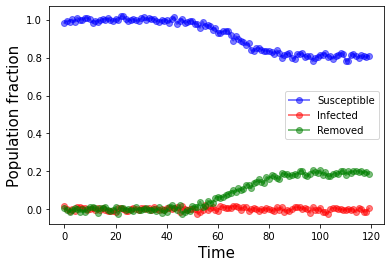

Training
Epoch 0, Loss= 0.08834576, beta= 0.0010, gamma= 0.0010 Time= 0.0025
Epoch 1000, Loss= 0.00771737, beta= 0.5552, gamma= 0.5392 Time= 0.0022
Epoch 2000, Loss= 0.00771625, beta= 0.8026, gamma= 0.7814 Time= 0.0022
Epoch 3000, Loss= 0.00771616, beta= 0.8326, gamma= 0.8107 Time= 0.0026
Epoch 4000, Loss= 0.00771612, beta= 0.8396, gamma= 0.8175 Time= 0.0026
Epoch 5000, Loss= 0.00771616, beta= 0.8431, gamma= 0.8210 Time= 0.0023
Epoch 6000, Loss= 0.00771608, beta= 0.8415, gamma= 0.8194 Time= 0.0023
Epoch 7000, Loss= 0.00771605, beta= 0.8445, gamma= 0.8222 Time= 0.0025
Epoch 8000, Loss= 0.00771605, beta= 0.8443, gamma= 0.8220 Time= 0.0023
Epoch 9000, Loss= 0.00771604, beta= 0.8449, gamma= 0.8225 Time= 0.0022
Epoch 10000, Loss= 0.00771603, beta= 0.8481, gamma= 0.8257 Time= 0.0022
Epoch 11000, Loss= 0.00771603, beta= 0.8482, gamma= 0.8258 Time= 0.0022
Epoch 12000, Loss= 0.00771603, beta= 0.8521, gamma= 0.8297 Time= 0.0022
Epoch 13000, Loss= 0.00771605, beta= 0.8492, gamma= 0.8268 Time= 0.0

In [5]:
param_list = [[0.3, 0.1], [0.25, 0.1], [0.3, 0.2] ,  [0.2, 0.1], [0.8, 0.25], [0.8, 0.45], [1.2, 0.25], [1.2, 0.45], [1.2, 0.95], [1.5, 0.25], [1.5, 0.95], [1.5, 1.35]]

t_max_ = [250, 250, 250, 250, 120, 120, 80, 80, 80, 80, 80, 120 ]

layers = [3, 6]

noise_level = 0.01

beta_model_ = []
gamma_model_ = []
beta_data_ = []
gamma_data_ = []

for j in range(len(param_list)):

    beta = param_list[j][0]
    gamma = param_list[j][1]

    beta_data_.append(beta)
    gamma_data_.append(gamma)

    print('SIR parameters:')
    print('beta = ', beta)
    print('gamma = ', gamma)

    s, i, t = data_SIR(beta, gamma, t_max= t_max_[j], noisy= True, noise_level= noise_level)

    print('Training')
    beta_model, gamma_model = train(s, i, t, layers)

    beta_model_.append(beta_model)
    gamma_model_.append(gamma_model)

    print('-----------')

    print('beta_expected= %.4f, beta_discovered= %.4f' % (beta, beta_model))
    print('gamma_expected= %.4f, gamma_discovered= %.4f' % (gamma, gamma_model))
 
    print('  ')
    print('  ')
    print('  ')

## SEIHCR model

Based on [COVID-19-Scenarios](https://neherlab.org/covid19/about)

In [46]:
def SEIHCR(params, N= 1000000, t_max= 250):

    def beta_(t):
        x = 2.7
        return x


    def SEIRHCR_model(y, t, N, params_):
        
        S, E, I, H, C, R, D = y

        gamma_L, gamma_IR, gamma_IH, f_IR, gamma_C, gamma_H, f_HC, f_CD = params_
        beta = beta_(t)
        
        dSdt = - beta*S* I /N
        dEdt = beta*S* I /N - gamma_L* E
        dIdt = gamma_L* E - gamma_IR*f_IR* I - gamma_IH*(1. - f_IR)* I
        dHdt = gamma_IH*(1. - f_IR)* I + gamma_C*(1. - f_CD)* C - gamma_H* H
        dCdt = gamma_H*f_HC* H - gamma_C* C
        dRdt = gamma_IR*f_IR* I + gamma_H*(1. - f_HC) *H
        dDdt = f_CD*gamma_C* C
        
        return dSdt, dEdt, dIdt, dHdt, dCdt, dRdt, dDdt

    E0, I0, H0, C0, R0, D0 = 0, 1, 0, 0, 0, 0

    # Everyone else, S0, is susceptible to infection initially.
    S0 = N - E0 - I0 - H0 - C0 - R0 - D0

    # Grid of time poins, in days
    dt = 1
    t = np.arange(0, t_max, dt)

    # Initial conditions vector
    y0 = S0, E0, I0, H0, C0, R0, D0

    # Integrate the SIR equations over the time grid, t.
    ret = odeint(SEIRHCR_model, y0, t, args=(N, params))
    S, E, I, H, C, R, D = ret.T

    s = torch.from_numpy(S / N).type(torch.float32)
    e = torch.from_numpy(E / N).type(torch.float32)
    i = torch.from_numpy(I / N).type(torch.float32)
    h = torch.from_numpy(H / N).type(torch.float32)
    c = torch.from_numpy(C / N).type(torch.float32)
    r = torch.from_numpy(R / N).type(torch.float32)
    d = torch.from_numpy(D / N).type(torch.float32)
    t_ = torch.from_numpy(t).type(torch.float32)

    plt.plot(t, s, color= 'C0', label='S', marker= 'o', alpha=0.5, lw=2)
    plt.plot(t, e, color= 'C1', label='E', marker= 'o', alpha=0.5, lw=2)
    plt.plot(t, i, color= 'C2', label='I', marker= 'o', alpha=0.5, lw=2)
    plt.plot(t, h, color= 'C3', label='H', marker= 'o', alpha=0.5, lw=2)
    plt.plot(t, c, color= 'C4', label='C', marker= 'o', alpha=0.5, lw=2)
    plt.plot(t, r, color= 'C5', label='R', marker= 'o', alpha=0.5, lw=2)
    plt.plot(t, d, color= 'C6', label='D', marker= 'o', alpha=0.5, lw=2)
    plt.xlabel('Time (days)', fontsize= 12)
    plt.ylabel('Population fraction', fontsize= 12)
    plt.xlim([-5, 150])
    plt.grid(linestyle=':')
    plt.legend(loc= 'lower right', fontsize= 8)
    plt.show()

    return s, e, i, h, c, r, d, t_


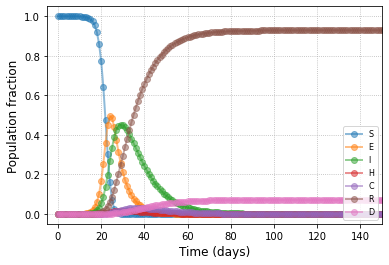

In [47]:
# Average incubation time scale 
gamma_L = 1./5
# average time an infected individual recovers without hospitalization
gamma_IR = 1./14
# average time an infected individual with mild symptoms goes to a critical condition (needs hospitalization)
gamma_IH = 1./5
# fraction of infectious that are asymptomatic or mild (no hospitalization).
f_IR = 0.7
# average time an infected individual in critical case (ICU) dies or gets better to leave the ICU$.
gamma_C = 1./7
# average time a hospitalized person recovers or deteriorates to a critical state.
gamma_H = 1.7
# fraction of hospitalized cases that turn to critical
f_HC = 0.2
# fraction of critial cases that are fatal
f_CD = 0.6

# Parameters
params = gamma_L, gamma_IR, gamma_IH, f_IR, gamma_C, gamma_H, f_HC, f_CD

s, e, i, h, c, r, d, t = SEIHCR(params= params, N= 1000000)

In [50]:
def train_SEIHCR(s, e, i, h, c, r, t, layers):

    model   = PINN_SEIHCR(s, 
                          e,
                          i,  
                          h, 
                          c,
                          r,                           
                          t, 
                          layers_size= layers,    # indentify from where this 3 comes from  
                          out_size = 6,     # psi and p
                          params_list= None)


    optimizer = optim.Adam(params= model.parameters(), 
                           lr= 0.001, 
                           weight_decay= 0.0)


    epochs = 100000

    for epoch in range(epochs):

        t0 = time.time()


        s_model, e_model, i_model, h_model, c_model, r_model, f_s, f_e, f_i, f_h, f_c, f_r = model.net(s,
                                                                                                       e, 
                                                                                                       i, 
                                                                                                       h, 
                                                                                                       c,
                                                                                                       r, 
                                                                                                       t)
        loss_ = model.loss(s, e, i, h, c, r,
                           s_model, e_model, i_model, h_model, c_model, r_model, 
                           f_s, f_e, f_i, f_h, f_c, f_r)
        
        loss_print  = loss_

        optimizer.zero_grad()   # Clear gradients for the next mini-batches
        loss_.backward()         # Backpropagation, compute gradients
        optimizer.step()

        
        ### Training status
        if epoch % 1000 == 0:

            t1 = time.time()
                
            print('It %d, Loss=%.4f, beta=%.4f, gamma_L=%.4f, gamma_IR=%.4f, gamma_IH=%.4f, f_IR=%.4f, gamma_C=%.4f, gamma_H=%.4f, f_HC=%.4f, f_CD=%.4f, Time=%.2f' % (epoch, 
                           loss_print,
                           list(model.parameters())[0].item(),
                           list(model.parameters())[1].item(),
                           list(model.parameters())[2].item(),
                           list(model.parameters())[3].item(),
                           list(model.parameters())[4].item(),
                           list(model.parameters())[5].item(),
                           list(model.parameters())[6].item(),
                           list(model.parameters())[7].item(),
                           list(model.parameters())[8].item(),
                           t1-t0))

    beta = list(model.parameters())[0].item()
    gamma_L = list(model.parameters())[1].item()
    gamma_IR = list(model.parameters())[2].item()
    gamma_IH = list(model.parameters())[3].item()
    f_IR = list(model.parameters())[4].item()
    gamma_C = list(model.parameters())[5].item()
    gamma_H = list(model.parameters())[6].item()
    f_HC = list(model.parameters())[7].item()
    f_CD = list(model.parameters())[8].item()


    return beta, gamma_L, gamma_IR, gamma_IH, f_IR, gamma_C, gamma_H, f_HC, f_CD

In [ ]:
# Average incubation time scale 
gamma_L = 1./5
# average time an infected individual recovers without hospitalization
gamma_IR = 1./14
# average time an infected individual with mild symptoms goes to a critical condition (needs hospitalization)
gamma_IH = 1./5
# fraction of infectious that are asymptomatic or mild (no hospitalization).
f_IR = 0.7
# average time an infected individual in critical case (ICU) dies or gets better to leave the ICU$.
gamma_C = 1./7
# average time a hospitalized person recovers or deteriorates to a critical state.
gamma_H = 1.7
# fraction of hospitalized cases that turn to critical
f_HC = 0.2
# fraction of critial cases that are fatal
f_CD = 0.6

In [55]:
 print('beta=%.4f, gamma_L=%.4f, gamma_IR=%.4f, gamma_IH=%.4f, f_IR=%.4f, gamma_C=%.4f, gamma_H=%.4f, f_HC=%.4f, f_CD=%.4f' % (2.7, gamma_L, gamma_IR, gamma_IH, f_IR, gamma_C, gamma_H, f_HC, f_CD))

beta=2.7000, gamma_L=0.2000, gamma_IR=0.0714, gamma_IH=0.2000, f_IR=0.7000, gamma_C=0.1429, gamma_H=1.7000, f_HC=0.2000, f_CD=0.6000


In [57]:
layers_ = [7, 20, 20, 20, 20, 20]

beta_, gamma_L_, gamma_IR_, gamma_IH_, f_IR_, gamma_C_, gamma_H_, f_HC_, f_CD_ = train_SEIHCR(s, e, i, h, c, r, t, layers= layers_)

It 0, Loss=14.5749, beta=0.0010, gamma_L=-0.0002, gamma_IR=0.0000, gamma_IH=0.0004, f_IR=0.0000, gamma_C=0.0000, gamma_H=-0.0000, f_HC=0.0000, f_CD=0.0000, Time=0.03
It 1000, Loss=0.1803, beta=0.0836, gamma_L=0.0061, gamma_IR=0.0500, gamma_IH=0.0000, f_IR=0.0625, gamma_C=-0.0000, gamma_H=0.0000, f_HC=0.0163, f_CD=0.0085, Time=0.01
It 2000, Loss=0.1799, beta=0.2492, gamma_L=0.0322, gamma_IR=0.1191, gamma_IH=0.0000, f_IR=0.1468, gamma_C=-0.0000, gamma_H=0.0000, f_HC=0.0163, f_CD=0.0085, Time=0.01
It 3000, Loss=0.1798, beta=0.4816, gamma_L=0.0707, gamma_IR=0.1777, gamma_IH=0.0000, f_IR=0.2168, gamma_C=-0.0000, gamma_H=0.0000, f_HC=0.0163, f_CD=0.0085, Time=0.01
It 4000, Loss=0.1797, beta=0.7466, gamma_L=0.1145, gamma_IR=0.2277, gamma_IH=0.0000, f_IR=0.2748, gamma_C=-0.0000, gamma_H=0.0000, f_HC=0.0163, f_CD=0.0085, Time=0.01
It 5000, Loss=0.1797, beta=0.9869, gamma_L=0.1545, gamma_IR=0.2664, gamma_IH=0.0000, f_IR=0.3179, gamma_C=-0.0000, gamma_H=0.0000, f_HC=0.0163, f_CD=0.0085, Time=0.01

In [58]:
layers_ = [7, 100]

beta_, gamma_L_, gamma_IR_, gamma_IH_, f_IR_, gamma_C_, gamma_H_, f_HC_, f_CD_ = train_SEIHCR(s, e, i, h, c, r, t, layers= layers_)

It 0, Loss=348.1188, beta=-0.0010, gamma_L=-0.0009, gamma_IR=0.0000, gamma_IH=0.0007, f_IR=0.0000, gamma_C=0.0000, gamma_H=0.0000, f_HC=0.0000, f_CD=0.0000, Time=0.05
It 1000, Loss=0.1898, beta=0.0054, gamma_L=0.0000, gamma_IR=0.0017, gamma_IH=-0.0000, f_IR=0.0032, gamma_C=0.0000, gamma_H=0.0000, f_HC=-0.0146, f_CD=0.0180, Time=0.01
It 2000, Loss=0.1813, beta=0.0164, gamma_L=0.0002, gamma_IR=0.0022, gamma_IH=0.0000, f_IR=0.0035, gamma_C=0.0000, gamma_H=0.0000, f_HC=-0.0146, f_CD=0.0180, Time=0.01
It 3000, Loss=0.1803, beta=0.0367, gamma_L=0.0008, gamma_IR=0.0056, gamma_IH=0.0001, f_IR=0.0059, gamma_C=-0.0000, gamma_H=-0.0000, f_HC=-0.0146, f_CD=0.0180, Time=0.01
It 4000, Loss=0.1800, beta=0.0700, gamma_L=0.0028, gamma_IR=0.0370, gamma_IH=0.0001, f_IR=0.0345, gamma_C=-0.0000, gamma_H=-0.0000, f_HC=-0.0146, f_CD=0.0180, Time=0.01
It 5000, Loss=0.1799, beta=0.1222, gamma_L=0.0078, gamma_IR=0.0667, gamma_IH=0.0000, f_IR=0.0622, gamma_C=-0.0000, gamma_H=-0.0000, f_HC=-0.0146, f_CD=0.0180, T

In [59]:
 layers_ = [7, 64, 48, 24, 12, 8]

beta_, gamma_L_, gamma_IR_, gamma_IH_, f_IR_, gamma_C_, gamma_H_, f_HC_, f_CD_ = train_SEIHCR(s, e, i, h, c, r, t, layers= layers_)

It 0, Loss=5.2527, beta=-0.0010, gamma_L=-0.0005, gamma_IR=0.0000, gamma_IH=0.0000, f_IR=0.0000, gamma_C=-0.0000, gamma_H=-0.0000, f_HC=0.0000, f_CD=0.0000, Time=0.05
It 1000, Loss=0.1798, beta=0.2188, gamma_L=0.0268, gamma_IR=0.1265, gamma_IH=-0.0000, f_IR=0.1157, gamma_C=-0.0000, gamma_H=-0.0005, f_HC=0.0023, f_CD=0.0233, Time=0.01
It 2000, Loss=0.1797, beta=0.5927, gamma_L=0.0906, gamma_IR=0.2323, gamma_IH=-0.0000, f_IR=0.2137, gamma_C=-0.0000, gamma_H=-0.0004, f_HC=0.0023, f_CD=0.0233, Time=0.01
It 3000, Loss=0.1797, beta=0.9371, gamma_L=0.1488, gamma_IR=0.2972, gamma_IH=-0.0000, f_IR=0.2749, gamma_C=-0.0000, gamma_H=-0.0004, f_HC=0.0023, f_CD=0.0233, Time=0.01
It 4000, Loss=0.1799, beta=1.1464, gamma_L=0.1717, gamma_IR=0.3312, gamma_IH=0.0009, f_IR=0.3083, gamma_C=-0.0003, gamma_H=-0.0002, f_HC=0.0023, f_CD=0.0234, Time=0.01
It 5000, Loss=0.1797, beta=1.2163, gamma_L=0.1953, gamma_IR=0.3388, gamma_IH=0.0001, f_IR=0.3166, gamma_C=-0.0004, gamma_H=0.0001, f_HC=0.0023, f_CD=0.0240, T